In [32]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

from braindecode.models import EEGNetv4
import copy
import random
import pandas as pd
from tqdm import notebook
import tqdm
from pathlib import Path
import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650'

# Net definition

In [ ]:
class FBCNN(nn.Module):
    def __init__(self, num_classes=8, channels=8, samples=250, subbands=3):
        super(FBCNN, self).__init__()
        # [batch, subbands, channels, time]
        # Subband combination layer
        self.subband_combination = nn.Conv2d(
            subbands, 1, kernel_size=(1, 1), bias=False
        )
        self.drop1 = nn.Dropout(0.2)
        self.frequency_combination = nn.Conv2d(1, 16, kernel_size=(channels, 1))
        self.drop2 = nn.Dropout(0.2)
        self.time_filter = nn.Conv2d(
            16,
            16,
            kernel_size=(1, samples // 2),
            padding="same",
        )
        self.relu1 = nn.ReLU()
        self.drop3 = nn.Dropout(0.2)

        # fourth layer - Time convolution and reducing dimension
        self.fourth_conv = nn.Conv2d(
            16, 16, kernel_size=(1, samples // 4), padding="same"
        )
        # Second dropout
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(1, 2))
        self.drop4 = nn.Dropout(0.5)

        # Fully connected layer - Classifier
        self.fc1 = nn.Linear(16 * (samples // 2), num_classes * 2)
        self.fc2 = nn.Linear(num_classes * 2, num_classes)
        self.drop5 = nn.Dropout(0.5)

        self._initialize_weights()

    def _initialize_weights(self):
        with torch.no_grad():
            self.subband_combination.weight.fill_(1.0)

    def forward(self, x):
        # x shape: [batch, subbands, channels, time]
        x = self.subband_combination(x)  # [batch, 1, channels, time]
        x = self.drop1(x)
        x = self.frequency_combination(x)  # [batch, 120, 1, time]
        x = self.drop2(x)
        x = self.time_filter(x)  # [batch, 120, channels, time]
        x = self.relu1(x)
        x = self.drop3(x)
        x = self.fourth_conv(x)  # [batch, 120, 1, time/2]
        x = self.relu2(x)
        x = self.pool(x)
        x = self.drop4(x)
        # x = self.fourth_conv(x)  # [batch, 120, 1, time/2]
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)  # [batch, num_classes * 2]
        x = self.drop5(x)
        x = self.fc2(x)  # [batch, num_classes]
        output = F.softmax(x, dim=1)
        return output

# Utilities

In [34]:
from cross_subject_utils import (
    plot_learning_curves,
    evaluate,
    get_windows,
    load_data_from_users,
    get_windows,
    filter_signals_subbands,
)

In [35]:
from cca import CCA_otimizacao, matriz_referencia

In [36]:
def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=100,
    device=0,
    save_path="best_model.pth",
):
    best_val_accuracy = -float("inf")
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in tqdm.notebook.tqdm(range(num_epochs)):
        # Training Phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # eval train
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_accuracy = train_correct / train_total
        avg_train_loss = running_loss / len(train_loader)

        # eval validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # val accuracy
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Save if best vall acc
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            # print(f"Best model saved with accuracy: {best_val_accuracy:.4f}")

        print(
            f"Epoch {epoch + 1}/{num_epochs}: "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
        )
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    model.load_state_dict(best_model)
    return model

# Cross Subject

In [ ]:
freq_phase_path = (
    "C:/Users/machi/Documents/Mestrado/repos/data/benchmark/Freq_Phase.mat"
)
freq_phase = scipy.io.loadmat(freq_phase_path)
frequencias = np.round(freq_phase["freqs"], 2).ravel()
fases = freq_phase["phases"]

# Parâmetros do pré-processamento
sample_rate = 250
delay = 160

# Parâmetros do CCA
num_harmonica = 5
inform_fase = 0

# Parâmetros de janelas e sessões
tamanho_da_janela_seg = 1
tamanho_da_janela = int(np.ceil(tamanho_da_janela_seg * sample_rate))
tamanho_da_janela_completa = (
    1250  # dataset benmhmark possui 5s de dados (1250 amostras) por trial
)

occipital_electrodes = np.array([47, 53, 54, 55, 56, 57, 60, 61, 62])
frequencias_desejadas = frequencias[:8]
indices = [np.where(frequencias == freq)[0][0] for freq in frequencias_desejadas]

# Usuários
# users = list(range(1, 36))  # Usuários de 1 a 35
users = list(range(1, 11))  # Usuários de 1 a 10

epochs = 300
exp_dir = Path(
    f"FBCNN_cca/{len(users)}_users_{len(frequencias_desejadas)}_freqs_{tamanho_da_janela_seg}_s/"
)

In [38]:
print("Usuários de interesse:", users)
print(f"Frequencies used: {frequencias_desejadas}")
print(f"Frequencies indices: {indices}")

Usuários de interesse: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Frequencies used: [ 8.  9. 10. 11. 12. 13. 14. 15.]
Frequencies indices: [0, 1, 2, 3, 4, 5, 6, 7]


In [9]:
all_data = load_data_from_users(
    users,
    visual_delay=delay,
    filter_bandpass=False,
    sample_rate=sample_rate,
)

Carregando dados dos usuários:   0%|          | 0/10 [00:00<?, ?it/s]

# Training

Processando Usuário 1
Train Users: [2, 3, 4, 5, 6, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (13500, 10)
Y_train shape after freq 8.0 Hz: (13500, 10, 8)
theta: 0
y shape: (250, 10)
Y shape: (1500, 10)
Y_test shape after freq 8.0 Hz: (1500, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (13500, 10)
Y_train shape after freq 9.0 Hz: (13500, 10, 8)
theta: 0
y shape: (250, 10)
Y shape: (1500, 10)
Y_test shape after freq 9.0 Hz: (1500, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (13500, 10)
Y_train shape after freq 10.0 Hz: (13500, 10, 8)
theta: 0
y shape: (250, 10)
Y shape: (1500, 10)
Y_test shape after freq 10.0 Hz: (1500, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (13500, 10)
Y_train shape after freq 11.0 Hz: (13500, 10, 8)
theta: 0


C:\Users\machi\AppData\Local\Temp\ipykernel_31060\1841888962.py:194: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
C:\Users\machi\AppData\Local\Temp\ipykernel_31060\1841888962.py:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300: Train Loss: 2.0758, Train Accuracy: 0.1008, Val Loss: 2.0887, Val Accuracy: 0.0923
Epoch 2/300: Train Loss: 2.0677, Train Accuracy: 0.1226, Val Loss: 2.0899, Val Accuracy: 0.0923
Epoch 3/300: Train Loss: 2.0587, Train Accuracy: 0.1308, Val Loss: 2.0916, Val Accuracy: 0.0923
Epoch 4/300: Train Loss: 2.0549, Train Accuracy: 0.1335, Val Loss: 2.0915, Val Accuracy: 0.0923
Epoch 5/300: Train Loss: 2.0628, Train Accuracy: 0.1226, Val Loss: 2.0895, Val Accuracy: 0.0923
Epoch 6/300: Train Loss: 2.0540, Train Accuracy: 0.1362, Val Loss: 2.0874, Val Accuracy: 0.0923
Epoch 7/300: Train Loss: 2.0548, Train Accuracy: 0.1308, Val Loss: 2.0860, Val Accuracy: 0.0923
Epoch 8/300: Train Loss: 2.0581, Train Accuracy: 0.1253, Val Loss: 2.0841, Val Accuracy: 0.0923
Epoch 9/300: Train Loss: 2.0538, Train Accuracy: 0.1253, Val Loss: 2.0831, Val Accuracy: 0.0923
Epoch 10/300: Train Loss: 2.0525, Train Accuracy: 0.1281, Val Loss: 2.0819, Val Accuracy: 0.0923
Epoch 11/300: Train Loss: 2.0498, Train

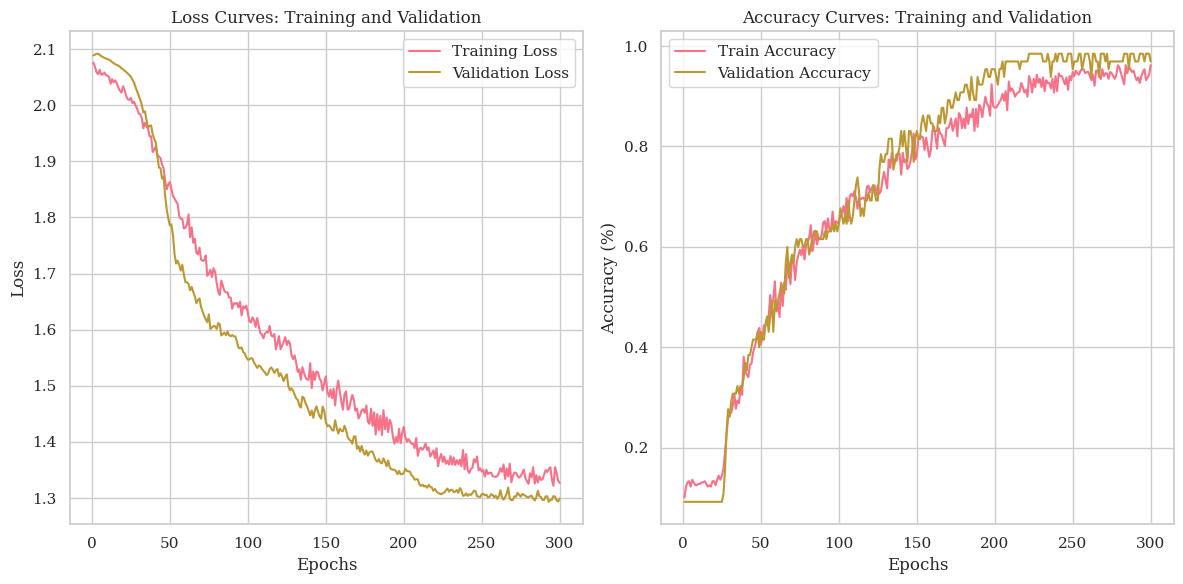

Test set Accuracy: 0.1250
Recall: 0.1250
F1 Score: 0.0278


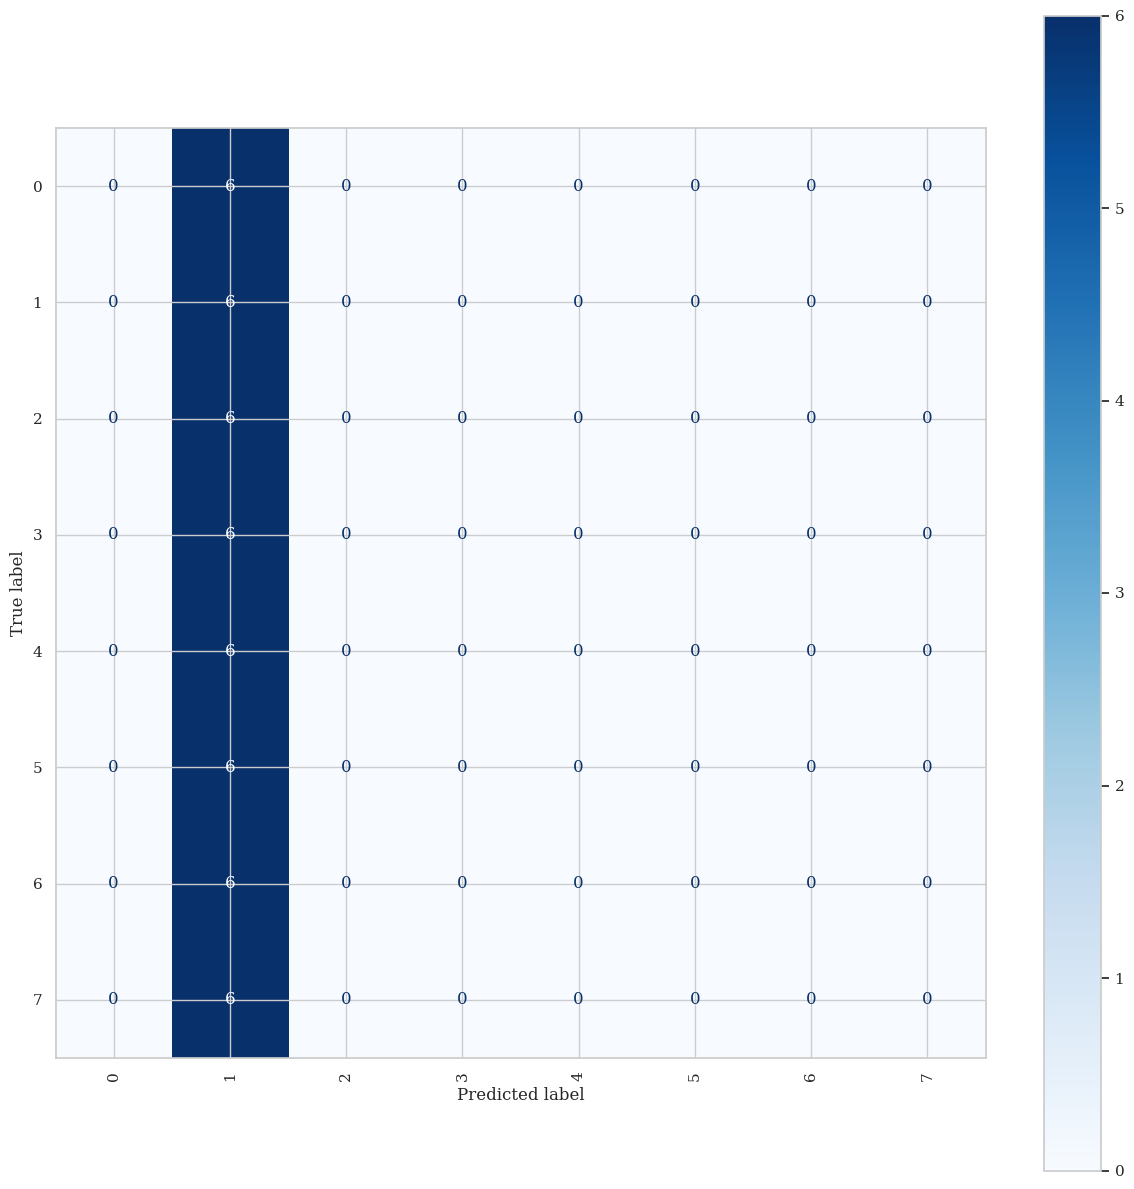

Test User 1 Finished: Accuracy=0.1250, Recall=0.1250, F1=0.0278
--------------------------------------------------
Processando Usuário 2
Train Users: [1, 3, 4, 5, 6, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (13500, 10)
Y_train shape after freq 8.0 Hz: (13500, 10, 8)
theta: 0
y shape: (250, 10)
Y shape: (1500, 10)
Y_test shape after freq 8.0 Hz: (1500, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (13500, 10)
Y_train shape after freq 9.0 Hz: (13500, 10, 8)
theta: 0
y shape: (250, 10)
Y shape: (1500, 10)
Y_test shape after freq 9.0 Hz: (1500, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (13500, 10)
Y_train shape after freq 10.0 Hz: (13500, 10, 8)
theta: 0
y shape: (250, 10)
Y shape: (1500, 10)
Y_test shape after freq 10.0 Hz: (1500, 10, 8)
3
Generating reference for frequency index 3, frequency 

C:\Users\machi\AppData\Local\Temp\ipykernel_31060\1841888962.py:194: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
C:\Users\machi\AppData\Local\Temp\ipykernel_31060\1841888962.py:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)


  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [63]:
seed = 42
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

metricas_usuarios = []
exp_dir.mkdir(parents=True, exist_ok=True)

# Prepare cross-subject splits
for test_user_idx, test_user in enumerate(users):
    print(f"Processando Usuário {test_user}")
    train_users = [u for u in users if u != test_user]
    print(f"Train Users: {train_users}")

    # Concatenate training data from all train_users
    train_data = np.concatenate(
        [all_data[users.index(u)] for u in train_users], axis=-1
    )  # shape: (channels, samples, freqs, trials)
    test_data = all_data[test_user_idx]

    num_canais, _, num_freqs, num_trials_train = train_data.shape
    num_trials_test = test_data.shape[-1]

    # Prepare reference matrices for all frequencies (no window separation)
    Y_train = np.zeros(
        (tamanho_da_janela * num_trials_train, num_harmonica * 2, len(indices))
    )
    Y_test = np.zeros(
        (tamanho_da_janela * num_trials_test, num_harmonica * 2, len(indices))
    )
    for k in indices:
        print(k)
        print(
            f"Generating reference for frequency index {k}, frequency {frequencias[k]} Hz"
        )
        y_train = matriz_referencia(
            num_harmonica,
            inform_fase,
            num_trials_train,
            frequencias[k],
            fases,
            tamanho_da_janela,
        )
        Y_train[:, :, k] = y_train
        print(f"Y_train shape after freq {frequencias[k]} Hz: {Y_train.shape}")
        y_test = matriz_referencia(
            num_harmonica,
            inform_fase,
            num_trials_test,
            frequencias[k],
            fases,
            tamanho_da_janela,
        )
        Y_test[:, :, k] = y_test
        print(f"Y_test shape after freq {frequencias[k]} Hz: {Y_test.shape}")

    X_train = np.zeros(
        (
            tamanho_da_janela * num_trials_train,
            3,
            len(occipital_electrodes),
            len(indices),
        )
    )
    X_test = np.zeros(
        (
            tamanho_da_janela * num_trials_test,
            3,
            len(occipital_electrodes),
            len(indices),
        )
    )

    for k in range(len(indices)):
        # For training: each trial is a single window
        eeg_matrix_train = train_data[
            occipital_electrodes, :tamanho_da_janela, indices[k], :
        ].reshape(-1, len(occipital_electrodes), tamanho_da_janela)
        eeg_matrix_train = filter_signals_subbands(
            eeg_matrix_train, subban_no=3, sampling_rate=250
        )
        eeg_matrix_test = test_data[
            occipital_electrodes, :tamanho_da_janela, indices[k], :
        ].reshape(-1, len(occipital_electrodes), tamanho_da_janela)
        eeg_matrix_test = filter_signals_subbands(
            eeg_matrix_test, subban_no=3, sampling_rate=250
        )

        eeg_matrix_train = np.moveaxis(eeg_matrix_train, -1, 0)
        eeg_matrix_test = np.moveaxis(eeg_matrix_test, -1, 0)
        eeg_matrix_train = np.concatenate(eeg_matrix_train, axis=0)
        eeg_matrix_test = np.concatenate(eeg_matrix_test, axis=0)

        X_train[:, :, :, k] = eeg_matrix_train
        X_test[:, :, :, k] = eeg_matrix_test

    # # CCA optimization (across all training data)
    Combinadores_Y = []
    Combinadores_X = []
    for i in range(3):
        Combinadores_Y_sub = []
        Combinadores_X_sub = []
        for k in range(len(indices)):
            Wx, Wy, _ = CCA_otimizacao(X_train[:, i, :, k], Y_train[:, :, k])
            Combinadores_Y_sub.append(Wy)
            Combinadores_X_sub.append(Wx)
        Combinadores_X.append(np.column_stack(Combinadores_X_sub))
        Combinadores_Y.append(np.column_stack(Combinadores_Y_sub))
    Combinadores_X = np.array(Combinadores_X)  # shape: (3, len(indices), channels)
    Combinadores_Y = np.array(
        Combinadores_Y
    )  # shape: (3, len(indices), 2*num_harmonica)

    # Separar em janelas
    X_teste_janelas = []
    X_treino_janelas = []
    Y_teste_janelas = []
    Y_treino_janelas = []

    for k in range(len(indices)):
        X_t, numero_janelas_teste = get_windows(
            X_test[:, :, :, k], tamanho_da_janela, include_last=False
        )
        Y_t, _ = get_windows(Y_test[:, :, k], tamanho_da_janela, include_last=False)

        X_v, numero_janelas_treino = get_windows(
            X_train[:, :, :, k], tamanho_da_janela, include_last=False
        )
        Y_v, _ = get_windows(Y_train[:, :, k], tamanho_da_janela, include_last=False)

        X_teste_janelas.append(X_t)
        Y_teste_janelas.append(Y_t)

        X_treino_janelas.append(X_v)
        Y_treino_janelas.append(Y_v)

    # Construir tensor de treinamento
    rotulos_treinamento = []
    tensor_treinamento = np.zeros(
        [len(indices) * num_trials_train, 3, len(indices), tamanho_da_janela]
    )
    cont = 0

    for m in range(len(indices)):
        for j in range(numero_janelas_treino):
            rotulos_treinamento.append(frequencias[indices[m]])
            cont_1 = 0
            for w in range(len(indices)):
                for subband in range(3):
                    Wx = Combinadores_X[subband, :, w]
                    janela_x = X_treino_janelas[m][j][:, subband, :]
                    projecao_x = np.dot(Wx, janela_x.T)
                    tensor_treinamento[cont, subband, cont_1, :] = projecao_x

                cont_1 += 1
            cont += 1

    rotulos_teste = []
    tensor_teste = np.zeros(
        [len(indices) * num_trials_test, 3, len(indices), tamanho_da_janela]
    )
    cont = 0

    for m in range(len(indices)):
        for j in range(numero_janelas_teste):
            rotulos_teste.append(frequencias[indices[m]])
            cont_1 = 0
            for w in range(len(indices)):
                for subband in range(3):
                    Wx = Combinadores_X[subband, :, w]
                    janela_x = X_teste_janelas[m][j][:, subband, :]
                    projecao_x = np.dot(Wx, janela_x.T)
                    tensor_teste[cont, subband, cont_1, :] = projecao_x

                cont_1 += 1
            cont += 1

    # Map labels to indices
    mapeamento = {rotulo: i for i, rotulo in enumerate(sorted(frequencias_desejadas))}
    rotulos_treinamento = torch.tensor(
        [
            mapeamento[rotulo.item()] if hasattr(rotulo, "item") else mapeamento[rotulo]
            for rotulo in rotulos_treinamento
        ]
    )
    rotulos_teste = torch.tensor(
        [
            mapeamento[rotulo.item()] if hasattr(rotulo, "item") else mapeamento[rotulo]
            for rotulo in rotulos_teste
        ]
    )

    X_treino = torch.tensor(tensor_treinamento, dtype=torch.float32).to(device)
    X_teste = torch.tensor(tensor_teste, dtype=torch.float32).to(device)
    Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
    Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)
    print("X_train:", X_treino.shape)
    print("X_test:", X_teste.shape)
    print("Y_train:", Y_treino.shape)
    print("Y_test:", Y_teste.shape)

    # Model setup
    model = FBCNN(
        num_classes=len(frequencias_desejadas),
        channels=len(frequencias_desejadas),
        samples=tamanho_da_janela,
        subbands=3,
    )
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

    dataset = TensorDataset(X_treino, Y_treino)
    train_size = int(0.85 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed)
    )
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(
        TensorDataset(X_teste, Y_teste), batch_size=10, shuffle=False
    )

    # Train
    best_model = train(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=epochs,
        device=device,
        save_path=exp_dir.joinpath(f"best_model_user_{test_user}.pth"),
    )

    # Evaluate
    accuracy, recall, f1, cm = evaluate(best_model, test_loader)

    metricas_usuarios.append(
        {
            "usuario": test_user,
            "acuracia": accuracy,
            "recall": recall,
            "f1-score": f1,
            "confusion_matrix": cm,
        }
    )
    print(
        f"Test User {test_user} Finished: Accuracy={accuracy:.4f}, Recall={recall:.4f}, F1={f1:.4f}"
    )

    # Salvar as métricas de cada usuário
    df_metricas = pd.DataFrame(metricas_usuarios)
    df_metricas.to_csv(exp_dir.joinpath("metricas.csv"), index=False)

    print("-" * 50)

# No fb-cca applied

Processando Usuário 1
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 3, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 3, 9, 250)
X_train: torch.Size([432, 3, 9, 250])
X_test: torch.Size([48, 3, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300: Train Loss: 2.0963, Train Accuracy: 0.0981, Val Loss: 2.0910, Val Accuracy: 0.0923
Epoch 2/300: Train Loss: 2.0828, Train Accuracy: 0.1499, Val Loss: 2.0857, Val Accuracy: 0.1077
Epoch 3/300: Train Loss: 2.0877, Train Accuracy: 0.1144, Val Loss: 2.0811, Val Accuracy: 0.1385
Epoch 4/300: Train Loss: 2.0815, Train Accuracy: 0.1335, Val Loss: 2.0772, Val Accuracy: 0.1538
Epoch 5/300: Train Loss: 2.0823, Train Accuracy: 0.1226, Val Loss: 2.0736, Val Accuracy: 0.1846
Epoch 6/300: Train Loss: 2.0741, Train Accuracy: 0.1580, Val Loss: 2.0736, Val Accuracy: 0.2154
Epoch 7/300: Train Loss: 2.0731, Train Accuracy: 0.1499, Val Loss: 2.0728, Val Accuracy: 0.2000
Epoch 8/300: Train Loss: 2.0663, Train Accuracy: 0.1689, Val Loss: 2.0715, Val Accuracy: 0.1846
Epoch 9/300: Train Loss: 2.0470, Train Accuracy: 0.2071, Val Loss: 2.0716, Val Accuracy: 0.2000
Epoch 10/300: Train Loss: 2.0345, Train Accuracy: 0.2316, Val Loss: 2.0702, Val Accuracy: 0.1692
Epoch 11/300: Train Loss: 2.0360, Train

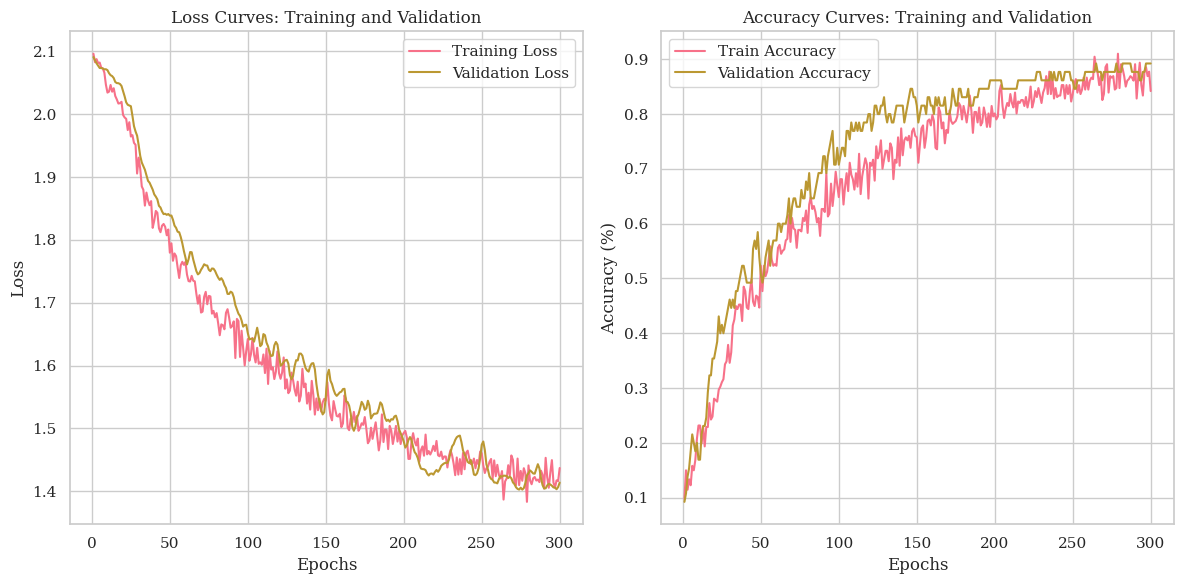

Test set Accuracy: 0.6875
Recall: 0.6875
F1 Score: 0.6544


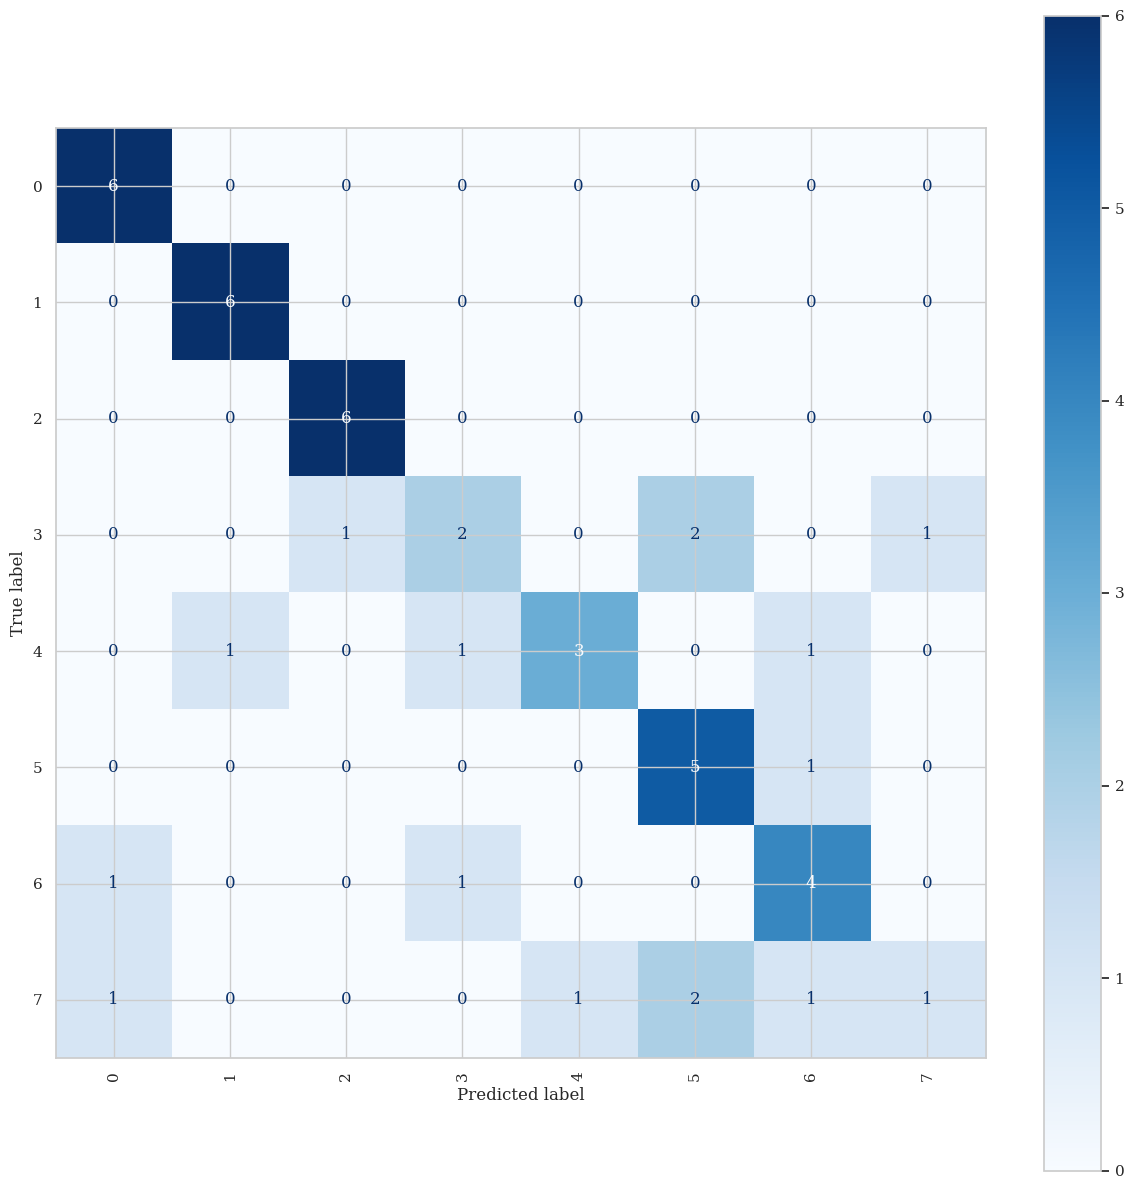

Usuário 1 Finalizado: Acurácia=0.6875, Recall=0.6875, F1=0.6544
--------------------------------------------------
Processando Usuário 2
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 3, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 3, 9, 250)
X_train: torch.Size([432, 3, 9, 250])
X_test: torch.Size([48, 3, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300: Train Loss: 2.0926, Train Accuracy: 0.1253, Val Loss: 2.0795, Val Accuracy: 0.1385
Epoch 2/300: Train Loss: 2.0938, Train Accuracy: 0.0872, Val Loss: 2.0770, Val Accuracy: 0.2154
Epoch 3/300: Train Loss: 2.0904, Train Accuracy: 0.1008, Val Loss: 2.0751, Val Accuracy: 0.2000
Epoch 4/300: Train Loss: 2.0820, Train Accuracy: 0.1499, Val Loss: 2.0734, Val Accuracy: 0.2154
Epoch 5/300: Train Loss: 2.0717, Train Accuracy: 0.1417, Val Loss: 2.0720, Val Accuracy: 0.2308
Epoch 6/300: Train Loss: 2.0707, Train Accuracy: 0.1689, Val Loss: 2.0701, Val Accuracy: 0.2769
Epoch 7/300: Train Loss: 2.0690, Train Accuracy: 0.1499, Val Loss: 2.0694, Val Accuracy: 0.2308
Epoch 8/300: Train Loss: 2.0675, Train Accuracy: 0.1826, Val Loss: 2.0693, Val Accuracy: 0.2615
Epoch 9/300: Train Loss: 2.0663, Train Accuracy: 0.1335, Val Loss: 2.0682, Val Accuracy: 0.2615
Epoch 10/300: Train Loss: 2.0607, Train Accuracy: 0.1471, Val Loss: 2.0688, Val Accuracy: 0.2615
Epoch 11/300: Train Loss: 2.0543, Train

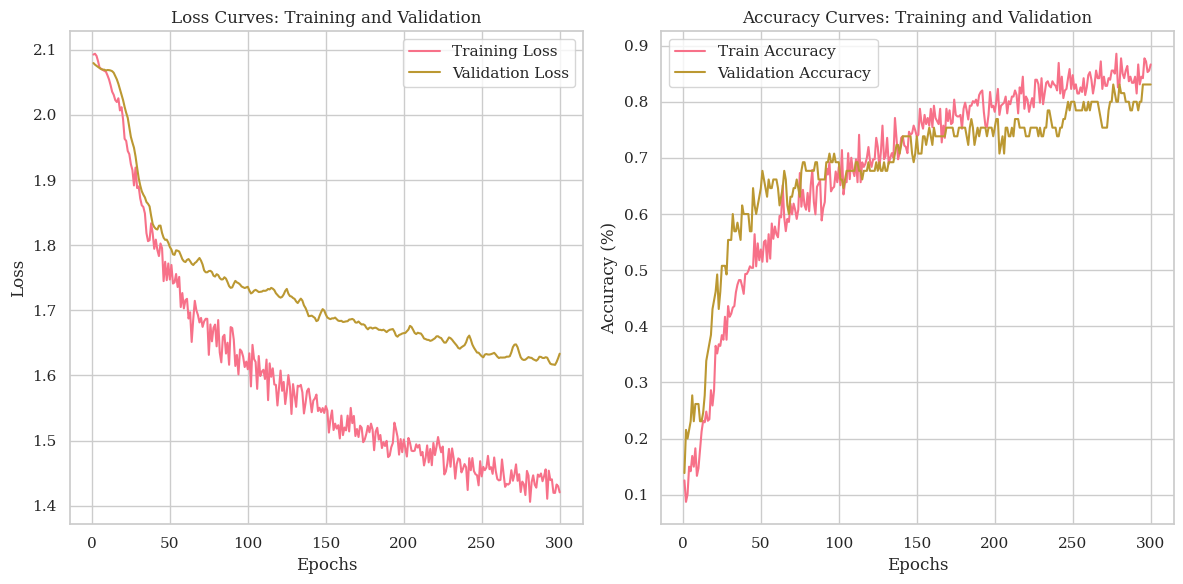

Test set Accuracy: 0.5208
Recall: 0.5208
F1 Score: 0.5103


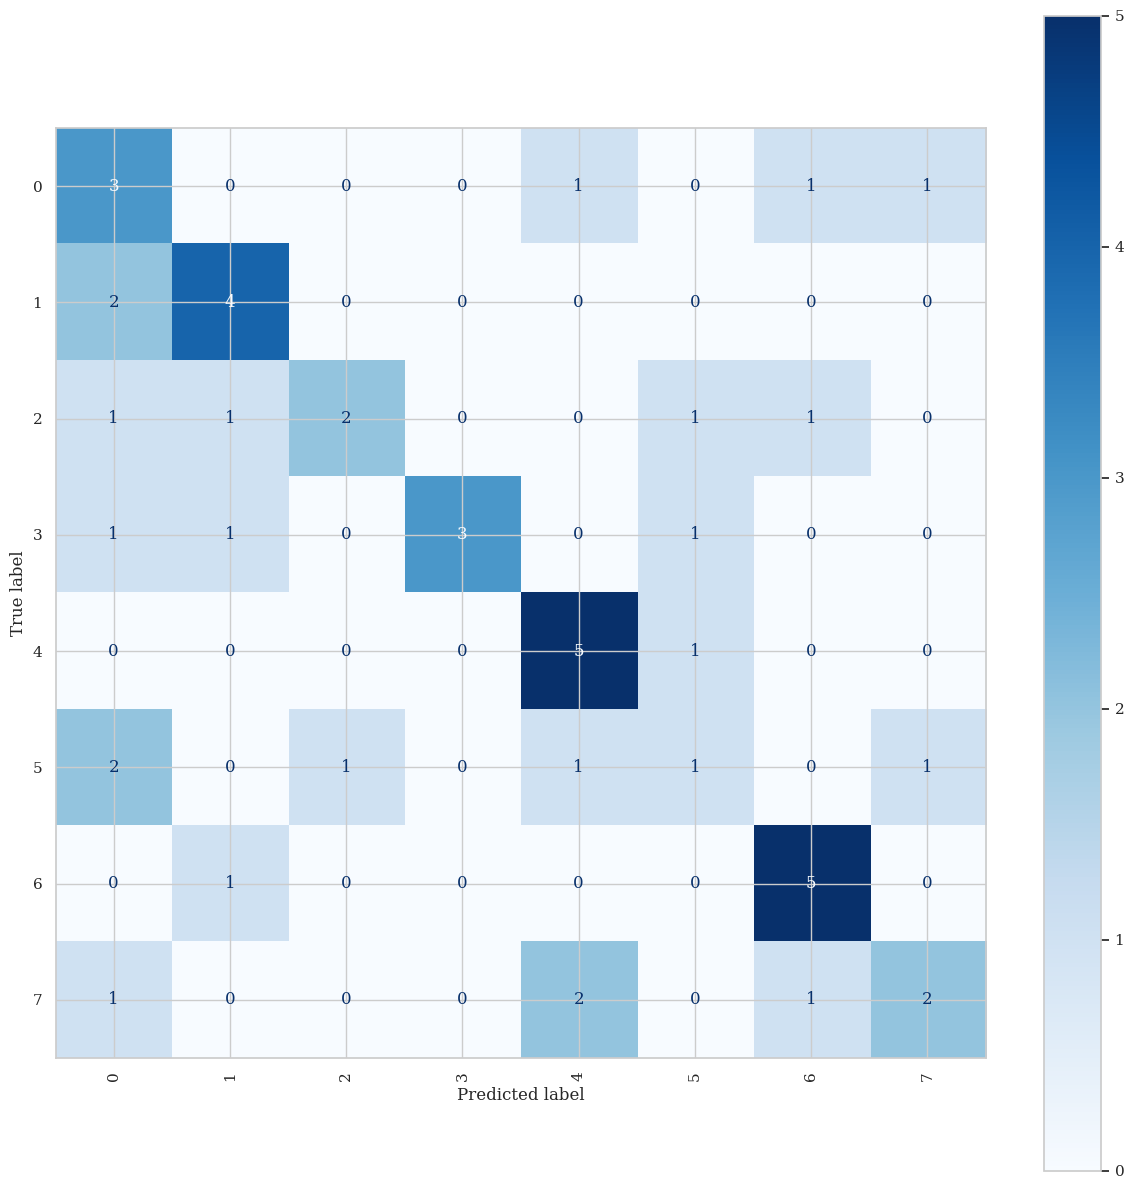

Usuário 2 Finalizado: Acurácia=0.5208, Recall=0.5208, F1=0.5103
--------------------------------------------------
Processando Usuário 3
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 3, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 3, 9, 250)
X_train: torch.Size([432, 3, 9, 250])
X_test: torch.Size([48, 3, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300: Train Loss: 2.0803, Train Accuracy: 0.1444, Val Loss: 2.0861, Val Accuracy: 0.1077
Epoch 2/300: Train Loss: 2.0920, Train Accuracy: 0.1253, Val Loss: 2.0867, Val Accuracy: 0.1231
Epoch 3/300: Train Loss: 2.0825, Train Accuracy: 0.1390, Val Loss: 2.0868, Val Accuracy: 0.1538
Epoch 4/300: Train Loss: 2.0707, Train Accuracy: 0.1580, Val Loss: 2.0868, Val Accuracy: 0.1077
Epoch 5/300: Train Loss: 2.0629, Train Accuracy: 0.1635, Val Loss: 2.0871, Val Accuracy: 0.1231
Epoch 6/300: Train Loss: 2.0591, Train Accuracy: 0.1744, Val Loss: 2.0873, Val Accuracy: 0.1692
Epoch 7/300: Train Loss: 2.0701, Train Accuracy: 0.1580, Val Loss: 2.0873, Val Accuracy: 0.1692
Epoch 8/300: Train Loss: 2.0727, Train Accuracy: 0.1608, Val Loss: 2.0845, Val Accuracy: 0.1692
Epoch 9/300: Train Loss: 2.0649, Train Accuracy: 0.1635, Val Loss: 2.0854, Val Accuracy: 0.1538
Epoch 10/300: Train Loss: 2.0646, Train Accuracy: 0.1608, Val Loss: 2.0860, Val Accuracy: 0.1231
Epoch 11/300: Train Loss: 2.0660, Train

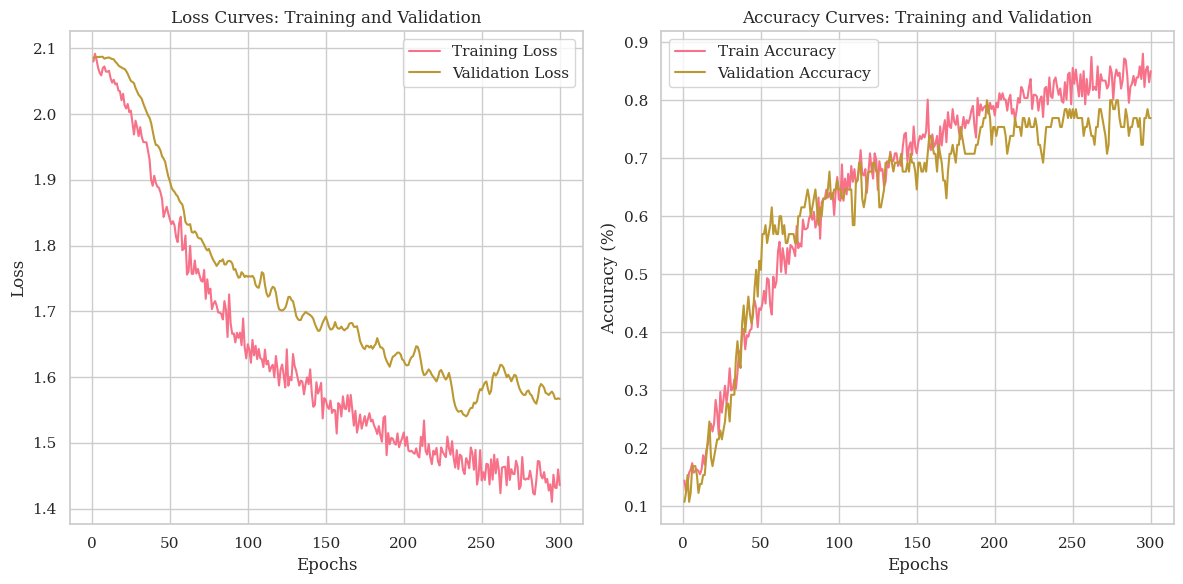

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000


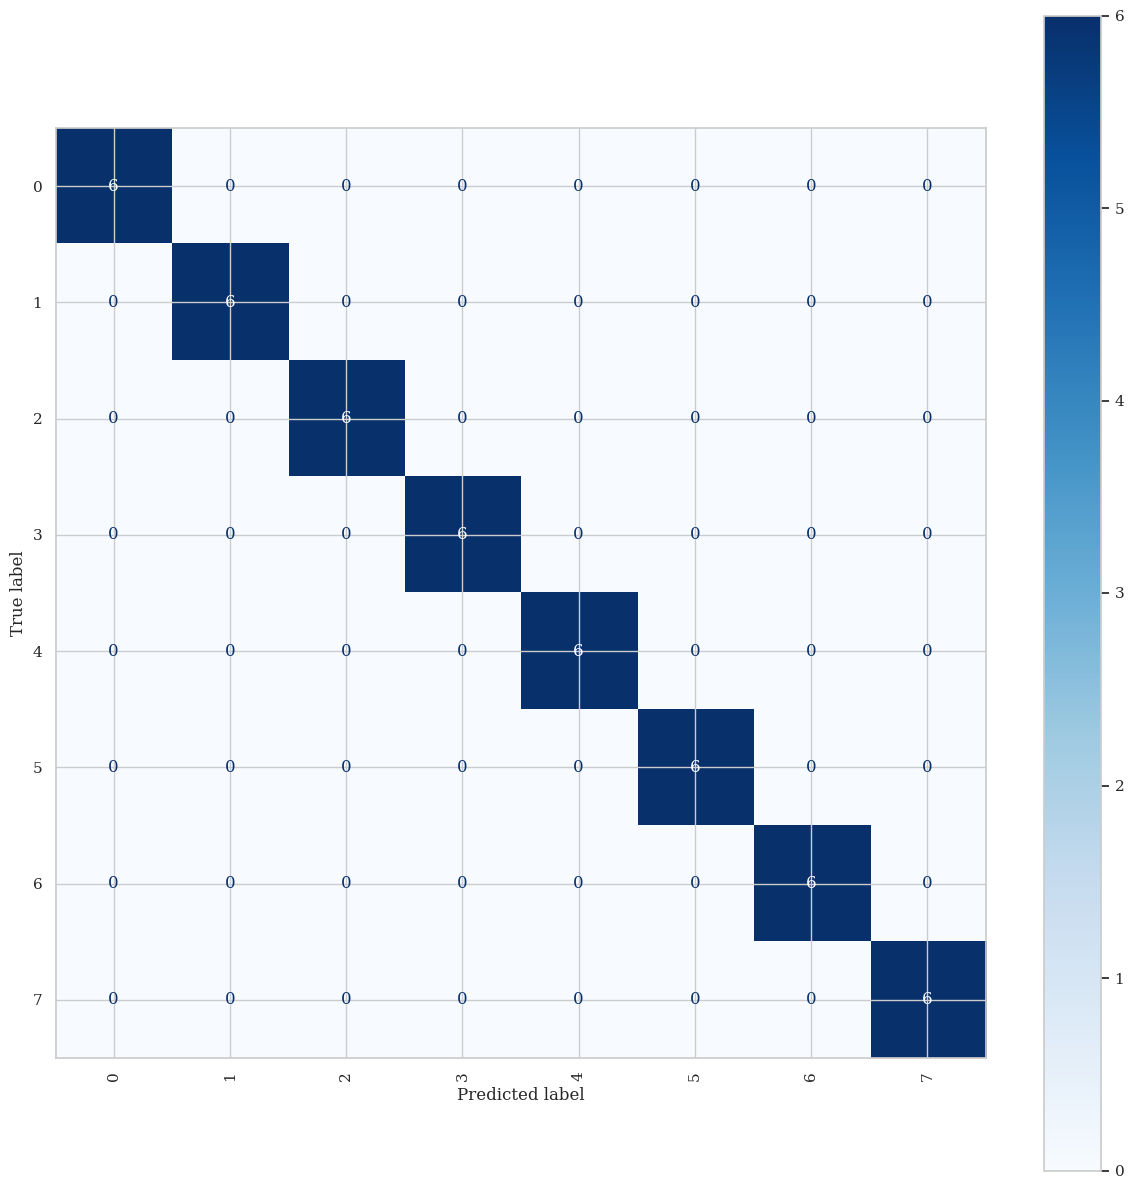

Usuário 3 Finalizado: Acurácia=1.0000, Recall=1.0000, F1=1.0000
--------------------------------------------------
Processando Usuário 4
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 3, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 3, 9, 250)
X_train: torch.Size([432, 3, 9, 250])
X_test: torch.Size([48, 3, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300: Train Loss: 2.0849, Train Accuracy: 0.1417, Val Loss: 2.0718, Val Accuracy: 0.0923
Epoch 2/300: Train Loss: 2.0894, Train Accuracy: 0.1253, Val Loss: 2.0720, Val Accuracy: 0.0923
Epoch 3/300: Train Loss: 2.0791, Train Accuracy: 0.1390, Val Loss: 2.0733, Val Accuracy: 0.0923
Epoch 4/300: Train Loss: 2.0847, Train Accuracy: 0.1335, Val Loss: 2.0744, Val Accuracy: 0.1077
Epoch 5/300: Train Loss: 2.0708, Train Accuracy: 0.1662, Val Loss: 2.0755, Val Accuracy: 0.0923
Epoch 6/300: Train Loss: 2.0748, Train Accuracy: 0.1471, Val Loss: 2.0764, Val Accuracy: 0.0923
Epoch 7/300: Train Loss: 2.0599, Train Accuracy: 0.1798, Val Loss: 2.0772, Val Accuracy: 0.1077
Epoch 8/300: Train Loss: 2.0740, Train Accuracy: 0.1526, Val Loss: 2.0783, Val Accuracy: 0.0923
Epoch 9/300: Train Loss: 2.0662, Train Accuracy: 0.1771, Val Loss: 2.0781, Val Accuracy: 0.1077
Epoch 10/300: Train Loss: 2.0649, Train Accuracy: 0.1798, Val Loss: 2.0778, Val Accuracy: 0.1385
Epoch 11/300: Train Loss: 2.0503, Train

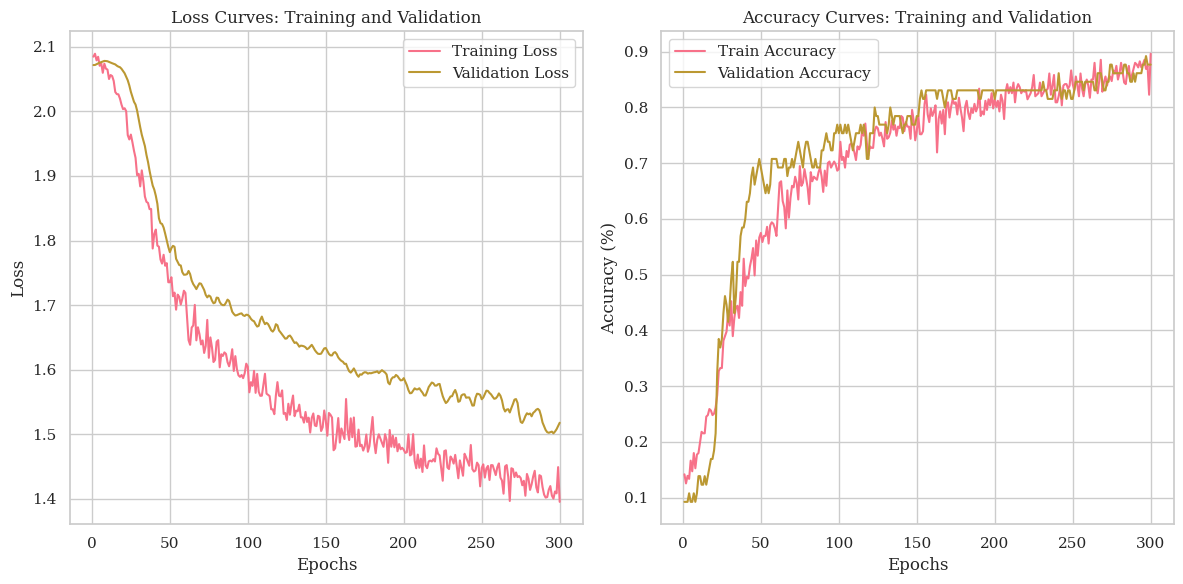

Test set Accuracy: 0.3958
Recall: 0.3958
F1 Score: 0.3707


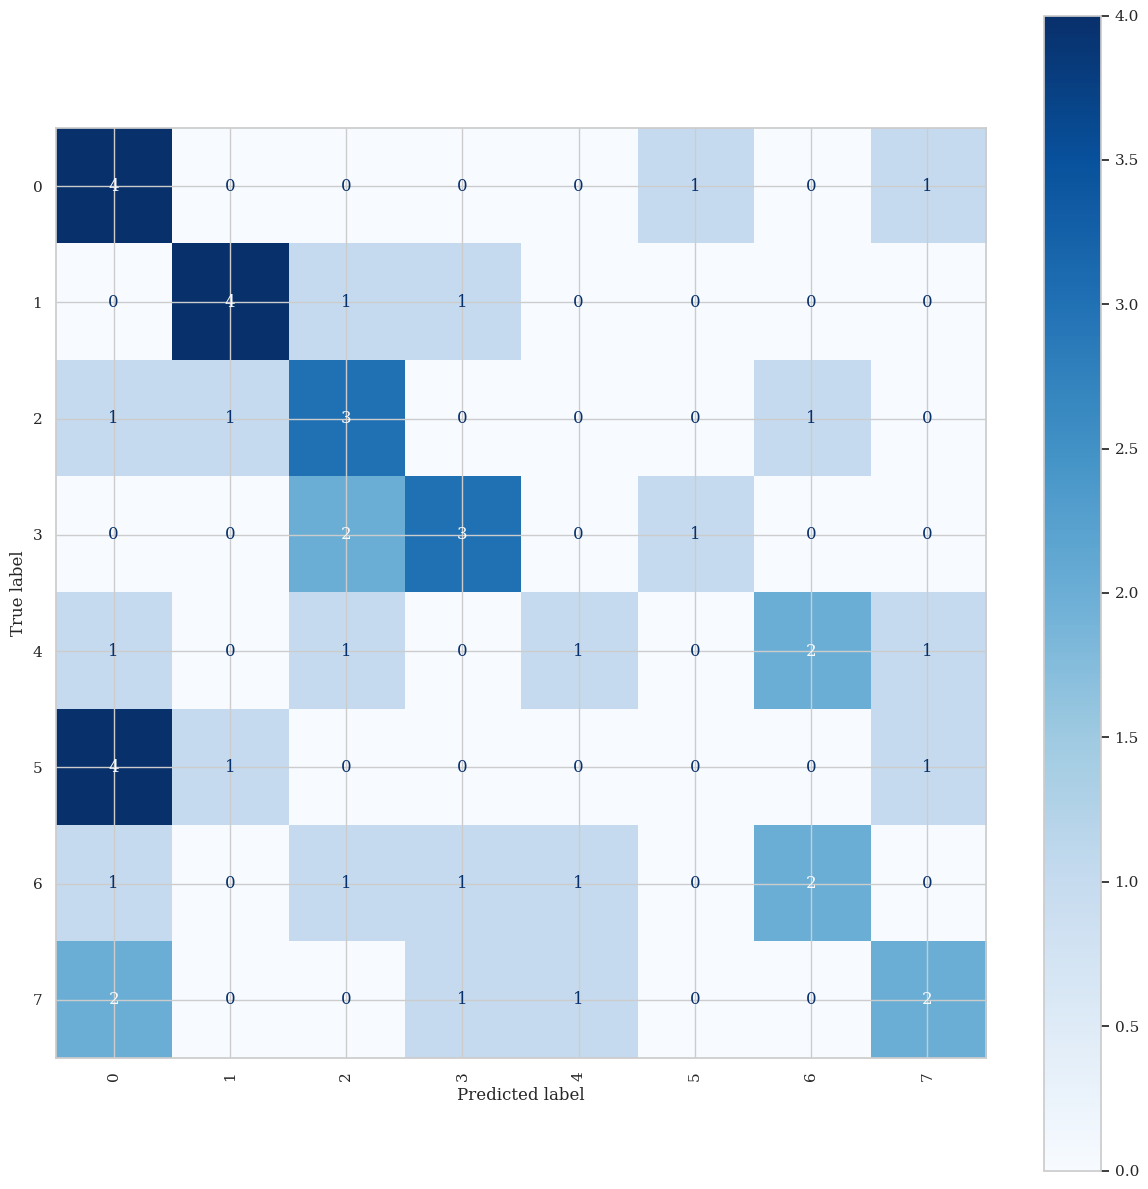

Usuário 4 Finalizado: Acurácia=0.3958, Recall=0.3958, F1=0.3707
--------------------------------------------------
Processando Usuário 5
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 3, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 3, 9, 250)
X_train: torch.Size([432, 3, 9, 250])
X_test: torch.Size([48, 3, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300: Train Loss: 2.0898, Train Accuracy: 0.1281, Val Loss: 2.0798, Val Accuracy: 0.1231
Epoch 2/300: Train Loss: 2.0938, Train Accuracy: 0.0845, Val Loss: 2.0785, Val Accuracy: 0.1385
Epoch 3/300: Train Loss: 2.0767, Train Accuracy: 0.1553, Val Loss: 2.0785, Val Accuracy: 0.1538
Epoch 4/300: Train Loss: 2.0651, Train Accuracy: 0.1662, Val Loss: 2.0769, Val Accuracy: 0.1692
Epoch 5/300: Train Loss: 2.0768, Train Accuracy: 0.1308, Val Loss: 2.0740, Val Accuracy: 0.2154
Epoch 6/300: Train Loss: 2.0682, Train Accuracy: 0.1689, Val Loss: 2.0713, Val Accuracy: 0.2154
Epoch 7/300: Train Loss: 2.0707, Train Accuracy: 0.1390, Val Loss: 2.0693, Val Accuracy: 0.2000
Epoch 8/300: Train Loss: 2.0769, Train Accuracy: 0.1226, Val Loss: 2.0671, Val Accuracy: 0.2308
Epoch 9/300: Train Loss: 2.0414, Train Accuracy: 0.2098, Val Loss: 2.0647, Val Accuracy: 0.2308
Epoch 10/300: Train Loss: 2.0615, Train Accuracy: 0.1689, Val Loss: 2.0618, Val Accuracy: 0.2308
Epoch 11/300: Train Loss: 2.0450, Train

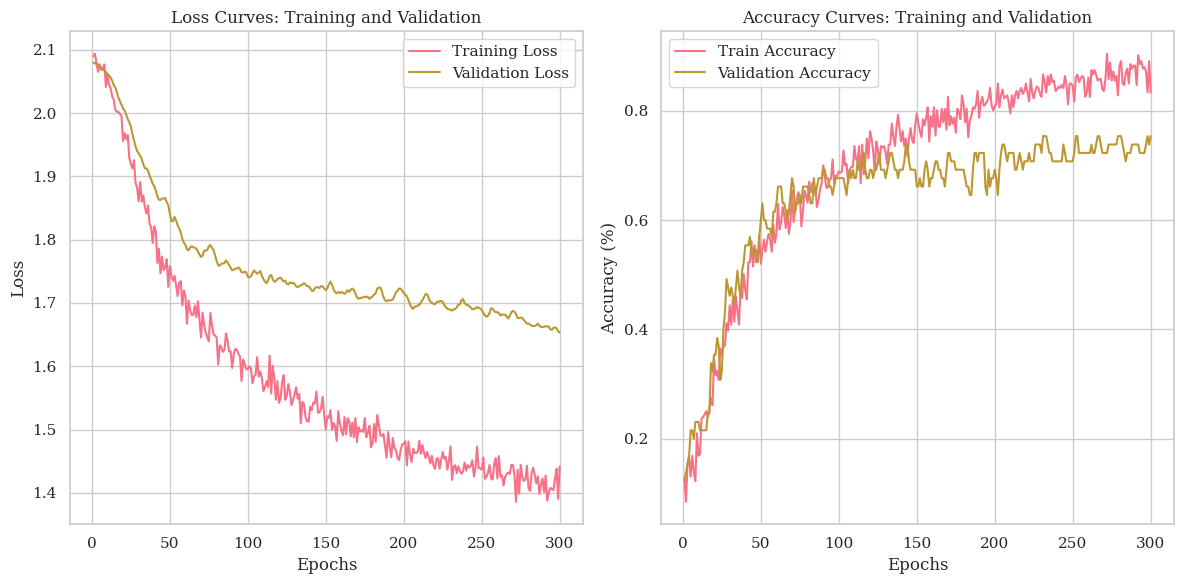

Test set Accuracy: 0.7708
Recall: 0.7708
F1 Score: 0.7562


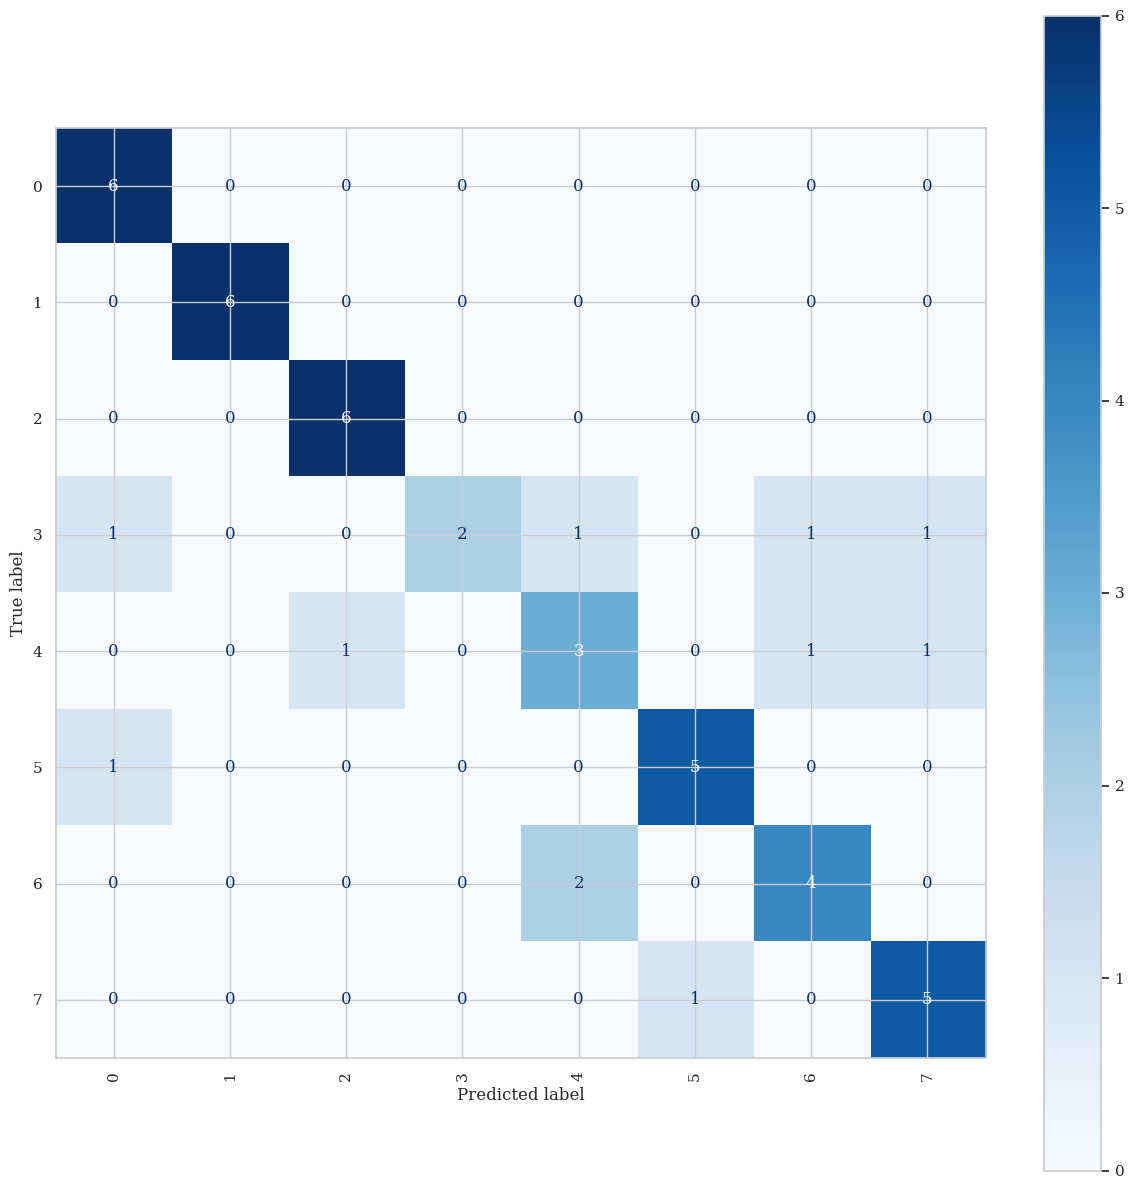

Usuário 5 Finalizado: Acurácia=0.7708, Recall=0.7708, F1=0.7562
--------------------------------------------------
Processando Usuário 6
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 3, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 3, 9, 250)
X_train: torch.Size([432, 3, 9, 250])
X_test: torch.Size([48, 3, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300: Train Loss: 2.0982, Train Accuracy: 0.1199, Val Loss: 2.0705, Val Accuracy: 0.1538
Epoch 2/300: Train Loss: 2.0681, Train Accuracy: 0.1526, Val Loss: 2.0701, Val Accuracy: 0.1538
Epoch 3/300: Train Loss: 2.0895, Train Accuracy: 0.1471, Val Loss: 2.0675, Val Accuracy: 0.1231
Epoch 4/300: Train Loss: 2.0765, Train Accuracy: 0.1580, Val Loss: 2.0636, Val Accuracy: 0.1231
Epoch 5/300: Train Loss: 2.0725, Train Accuracy: 0.1635, Val Loss: 2.0599, Val Accuracy: 0.1077
Epoch 6/300: Train Loss: 2.0731, Train Accuracy: 0.1417, Val Loss: 2.0581, Val Accuracy: 0.0923
Epoch 7/300: Train Loss: 2.0656, Train Accuracy: 0.1853, Val Loss: 2.0563, Val Accuracy: 0.0923
Epoch 8/300: Train Loss: 2.0728, Train Accuracy: 0.1526, Val Loss: 2.0546, Val Accuracy: 0.1077
Epoch 9/300: Train Loss: 2.0591, Train Accuracy: 0.1717, Val Loss: 2.0519, Val Accuracy: 0.1385
Epoch 10/300: Train Loss: 2.0450, Train Accuracy: 0.1826, Val Loss: 2.0492, Val Accuracy: 0.1692
Epoch 11/300: Train Loss: 2.0621, Train

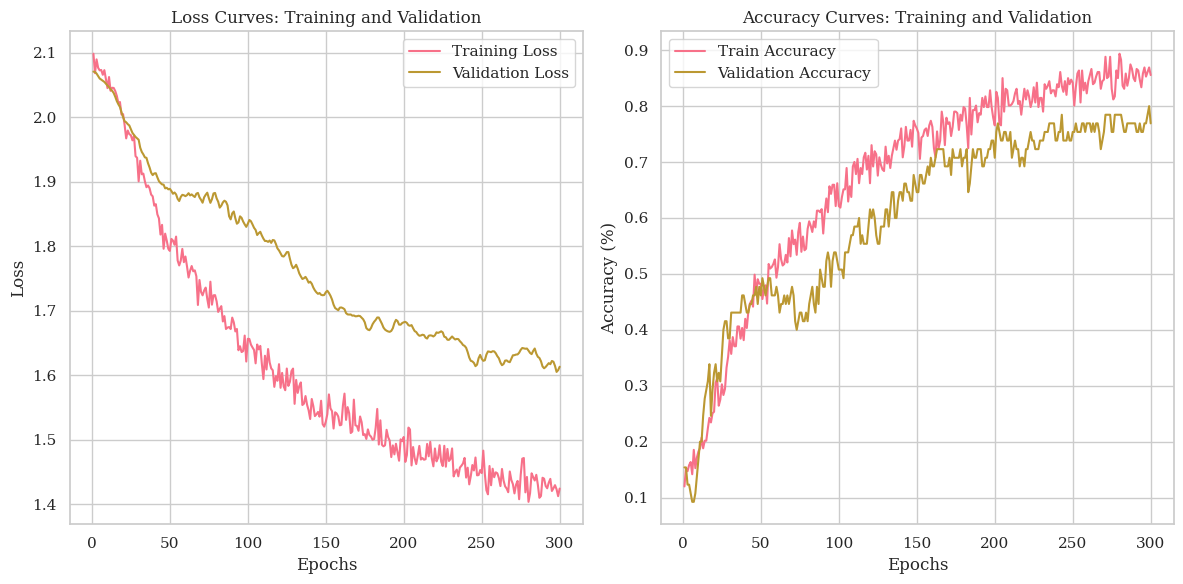

Test set Accuracy: 0.7917
Recall: 0.7917
F1 Score: 0.7810


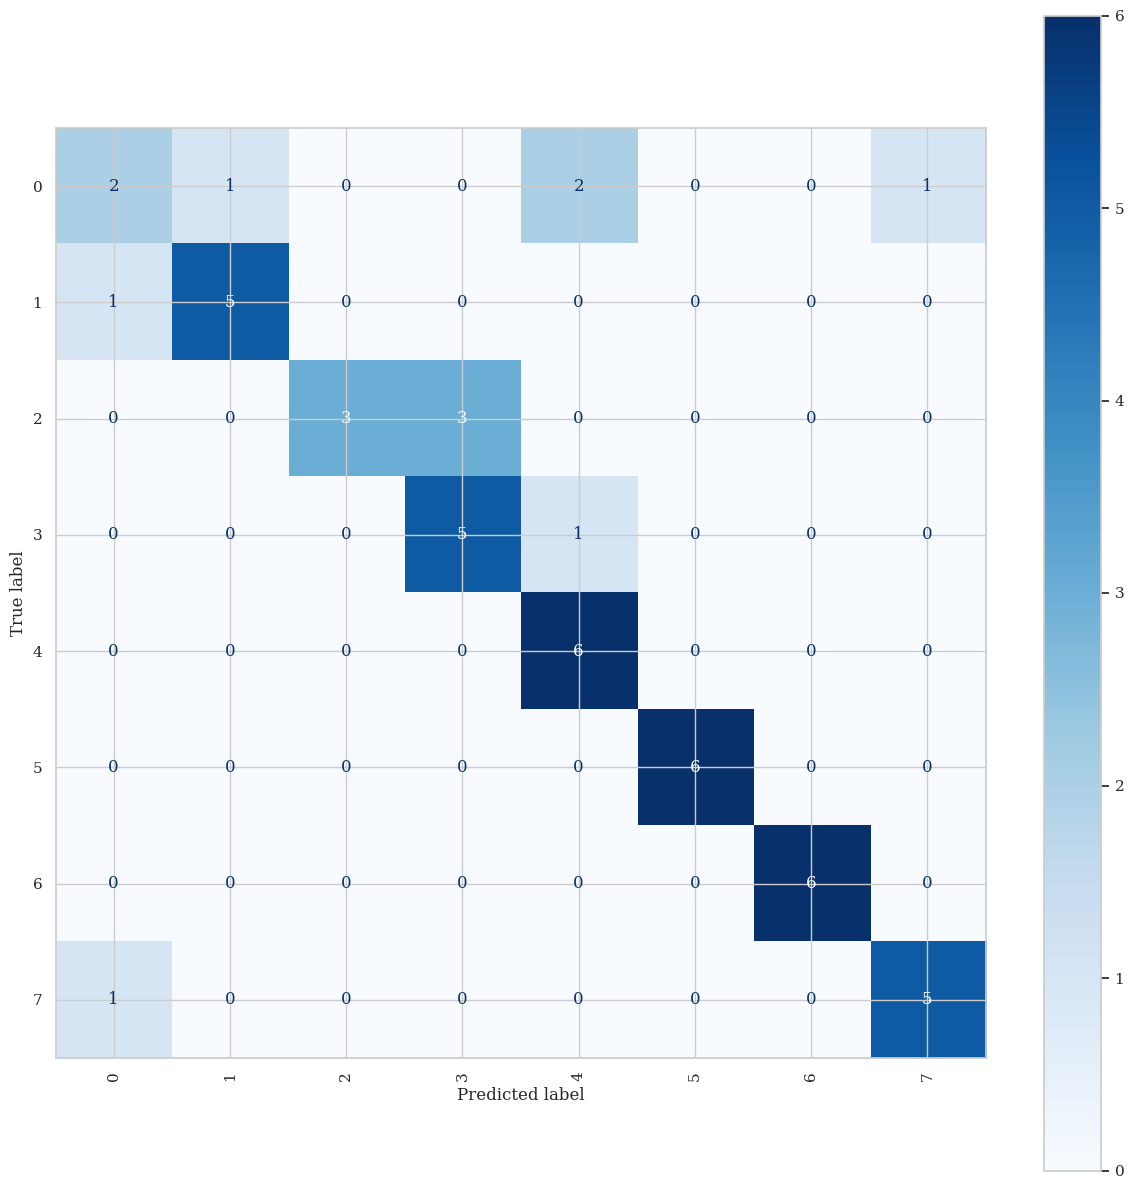

Usuário 6 Finalizado: Acurácia=0.7917, Recall=0.7917, F1=0.7810
--------------------------------------------------
Processando Usuário 7
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 3, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 3, 9, 250)
X_train: torch.Size([432, 3, 9, 250])
X_test: torch.Size([48, 3, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300: Train Loss: 2.0821, Train Accuracy: 0.1362, Val Loss: 2.0665, Val Accuracy: 0.1846
Epoch 2/300: Train Loss: 2.0875, Train Accuracy: 0.1390, Val Loss: 2.0658, Val Accuracy: 0.1538
Epoch 3/300: Train Loss: 2.0842, Train Accuracy: 0.1226, Val Loss: 2.0639, Val Accuracy: 0.1231
Epoch 4/300: Train Loss: 2.0807, Train Accuracy: 0.1390, Val Loss: 2.0618, Val Accuracy: 0.1231
Epoch 5/300: Train Loss: 2.0712, Train Accuracy: 0.1553, Val Loss: 2.0594, Val Accuracy: 0.1385
Epoch 6/300: Train Loss: 2.0763, Train Accuracy: 0.1580, Val Loss: 2.0589, Val Accuracy: 0.1231
Epoch 7/300: Train Loss: 2.0574, Train Accuracy: 0.2016, Val Loss: 2.0575, Val Accuracy: 0.1077
Epoch 8/300: Train Loss: 2.0677, Train Accuracy: 0.1526, Val Loss: 2.0567, Val Accuracy: 0.1077
Epoch 9/300: Train Loss: 2.0523, Train Accuracy: 0.1935, Val Loss: 2.0560, Val Accuracy: 0.1385
Epoch 10/300: Train Loss: 2.0520, Train Accuracy: 0.1853, Val Loss: 2.0531, Val Accuracy: 0.2462
Epoch 11/300: Train Loss: 2.0397, Train

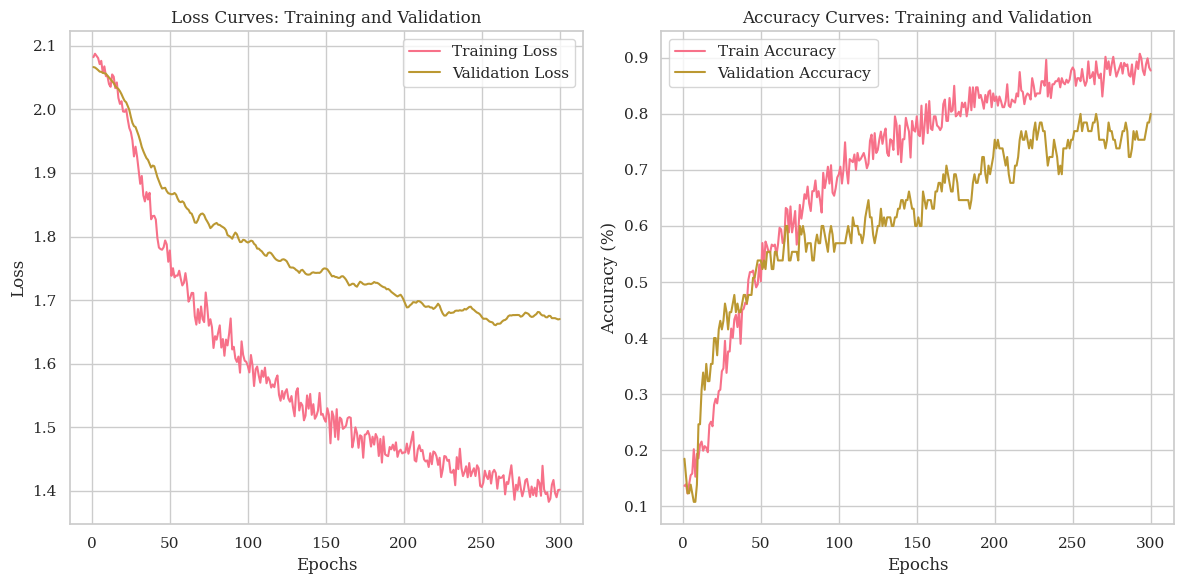

Test set Accuracy: 0.5208
Recall: 0.5208
F1 Score: 0.5073


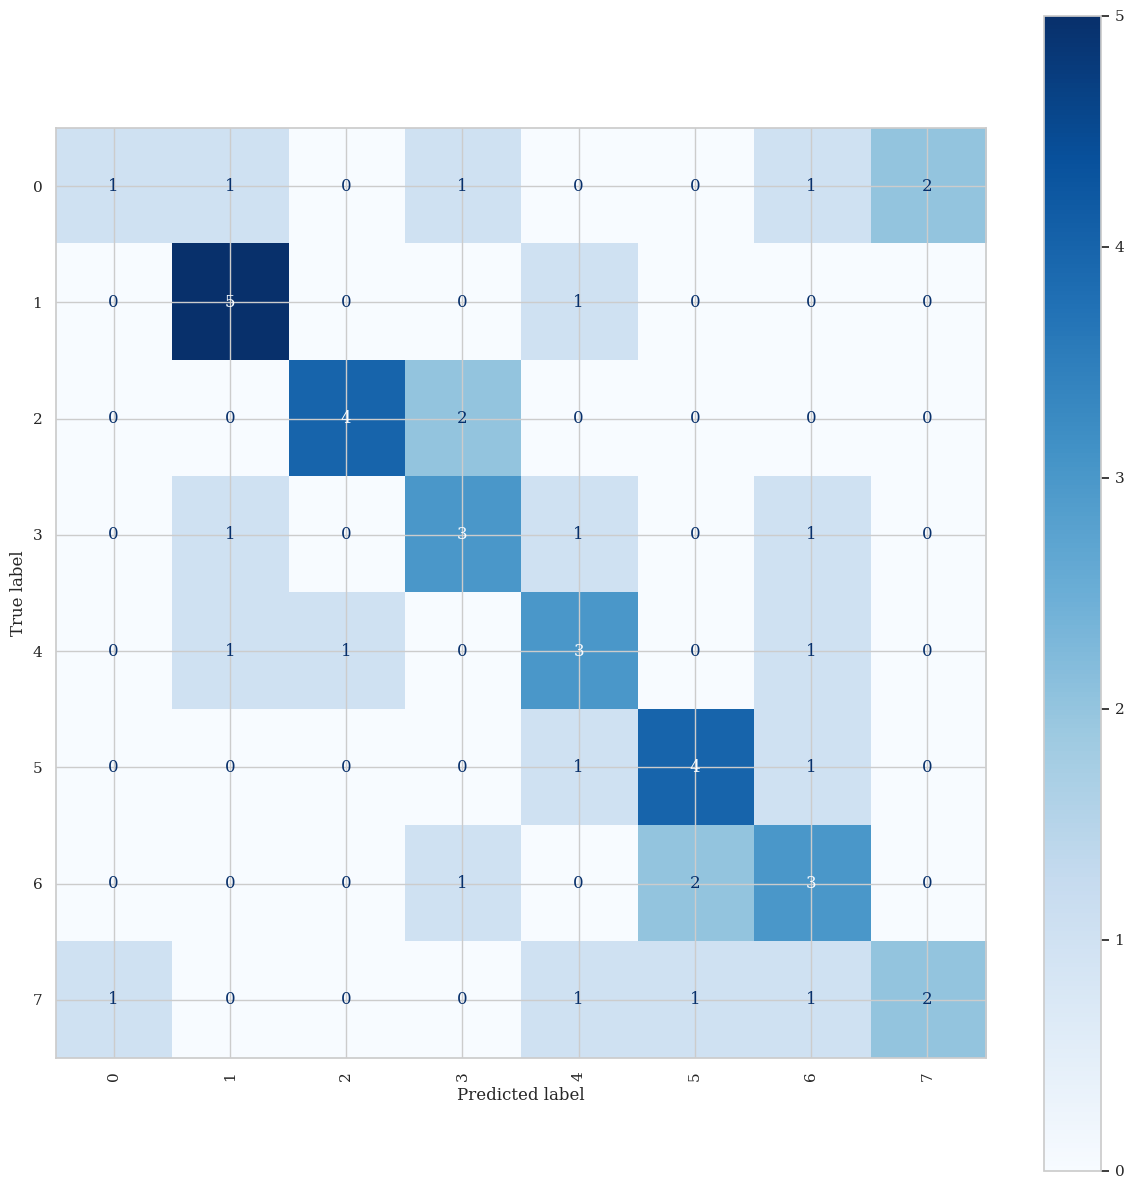

Usuário 7 Finalizado: Acurácia=0.5208, Recall=0.5208, F1=0.5073
--------------------------------------------------
Processando Usuário 8
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 3, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 3, 9, 250)
X_train: torch.Size([432, 3, 9, 250])
X_test: torch.Size([48, 3, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300: Train Loss: 2.0766, Train Accuracy: 0.1553, Val Loss: 2.0778, Val Accuracy: 0.2154
Epoch 2/300: Train Loss: 2.0902, Train Accuracy: 0.1417, Val Loss: 2.0809, Val Accuracy: 0.1538
Epoch 3/300: Train Loss: 2.0883, Train Accuracy: 0.1008, Val Loss: 2.0826, Val Accuracy: 0.1231
Epoch 4/300: Train Loss: 2.0791, Train Accuracy: 0.1362, Val Loss: 2.0832, Val Accuracy: 0.1231
Epoch 5/300: Train Loss: 2.0724, Train Accuracy: 0.1526, Val Loss: 2.0811, Val Accuracy: 0.1385
Epoch 6/300: Train Loss: 2.0806, Train Accuracy: 0.1362, Val Loss: 2.0795, Val Accuracy: 0.1077
Epoch 7/300: Train Loss: 2.0803, Train Accuracy: 0.1417, Val Loss: 2.0777, Val Accuracy: 0.1231
Epoch 8/300: Train Loss: 2.0622, Train Accuracy: 0.1771, Val Loss: 2.0770, Val Accuracy: 0.1077
Epoch 9/300: Train Loss: 2.0721, Train Accuracy: 0.1390, Val Loss: 2.0778, Val Accuracy: 0.0923
Epoch 10/300: Train Loss: 2.0744, Train Accuracy: 0.1390, Val Loss: 2.0797, Val Accuracy: 0.1231
Epoch 11/300: Train Loss: 2.0620, Train

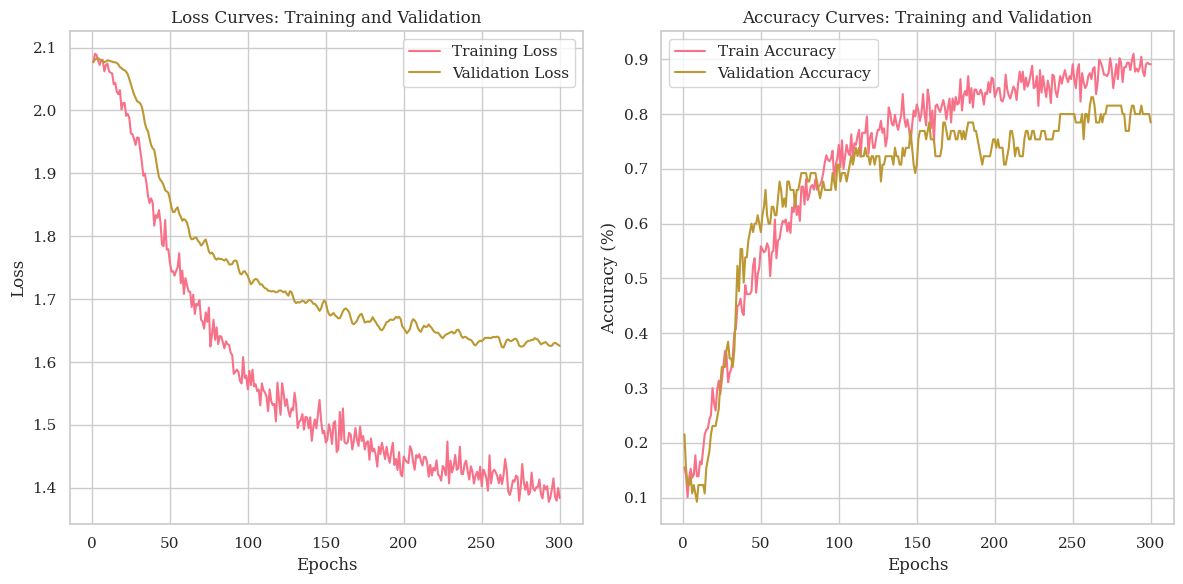

Test set Accuracy: 0.7917
Recall: 0.7917
F1 Score: 0.7927


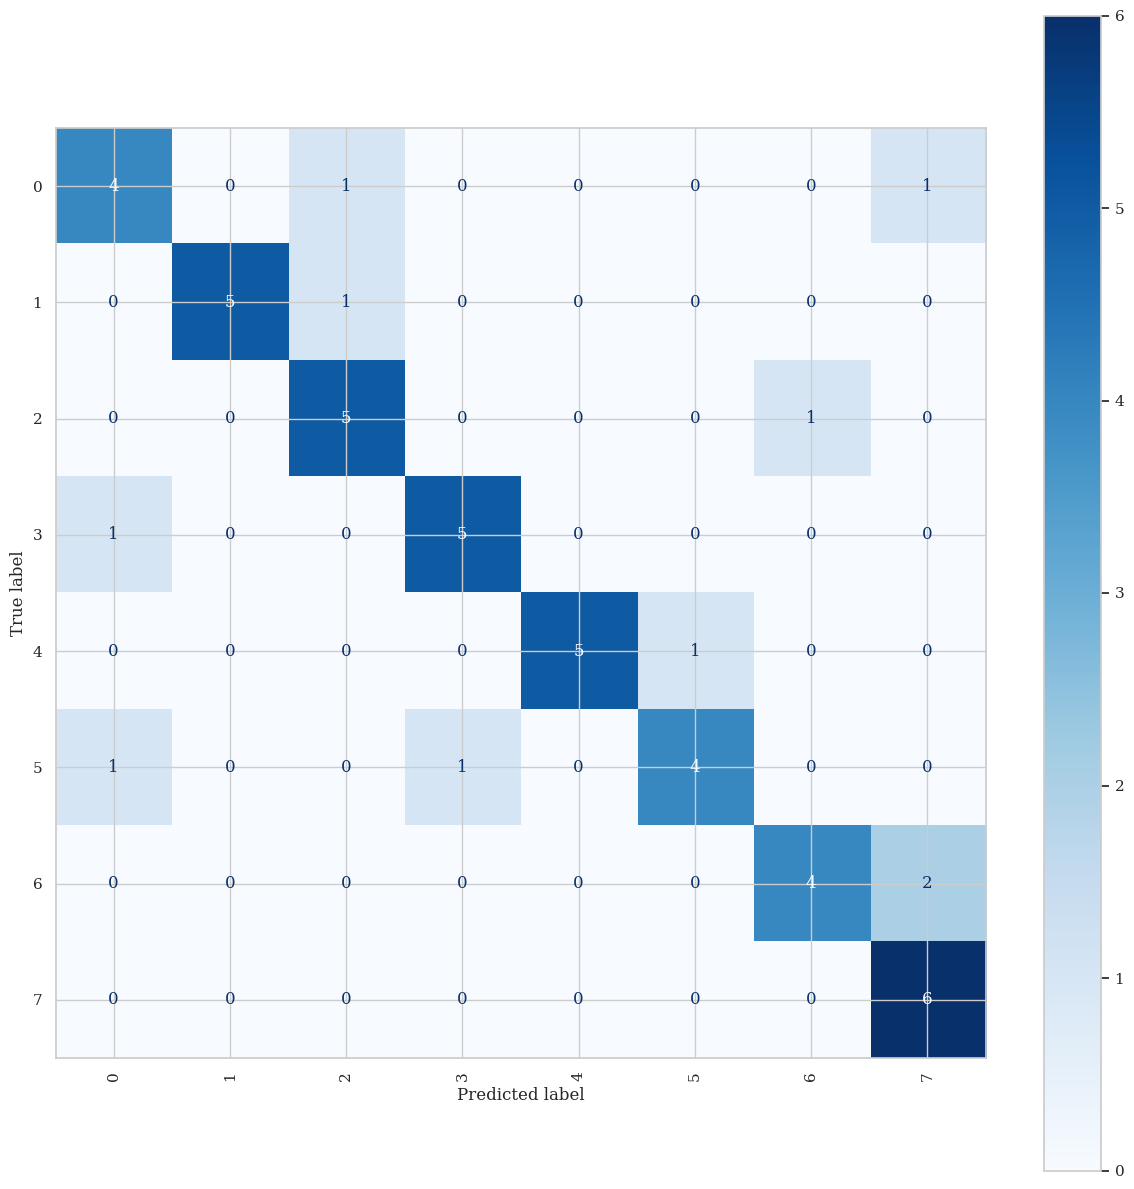

Usuário 8 Finalizado: Acurácia=0.7917, Recall=0.7917, F1=0.7927
--------------------------------------------------
Processando Usuário 9
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 3, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 3, 9, 250)
X_train: torch.Size([432, 3, 9, 250])
X_test: torch.Size([48, 3, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300: Train Loss: 2.0863, Train Accuracy: 0.1390, Val Loss: 2.0886, Val Accuracy: 0.1231
Epoch 2/300: Train Loss: 2.0774, Train Accuracy: 0.1499, Val Loss: 2.0880, Val Accuracy: 0.1846
Epoch 3/300: Train Loss: 2.0800, Train Accuracy: 0.1471, Val Loss: 2.0856, Val Accuracy: 0.1385
Epoch 4/300: Train Loss: 2.0874, Train Accuracy: 0.1117, Val Loss: 2.0845, Val Accuracy: 0.2308
Epoch 5/300: Train Loss: 2.0664, Train Accuracy: 0.1989, Val Loss: 2.0835, Val Accuracy: 0.1846
Epoch 6/300: Train Loss: 2.0778, Train Accuracy: 0.1471, Val Loss: 2.0810, Val Accuracy: 0.2154
Epoch 7/300: Train Loss: 2.0677, Train Accuracy: 0.1608, Val Loss: 2.0793, Val Accuracy: 0.2000
Epoch 8/300: Train Loss: 2.0548, Train Accuracy: 0.1853, Val Loss: 2.0778, Val Accuracy: 0.2615
Epoch 9/300: Train Loss: 2.0624, Train Accuracy: 0.1608, Val Loss: 2.0753, Val Accuracy: 0.2462
Epoch 10/300: Train Loss: 2.0587, Train Accuracy: 0.2016, Val Loss: 2.0730, Val Accuracy: 0.2923
Epoch 11/300: Train Loss: 2.0588, Train

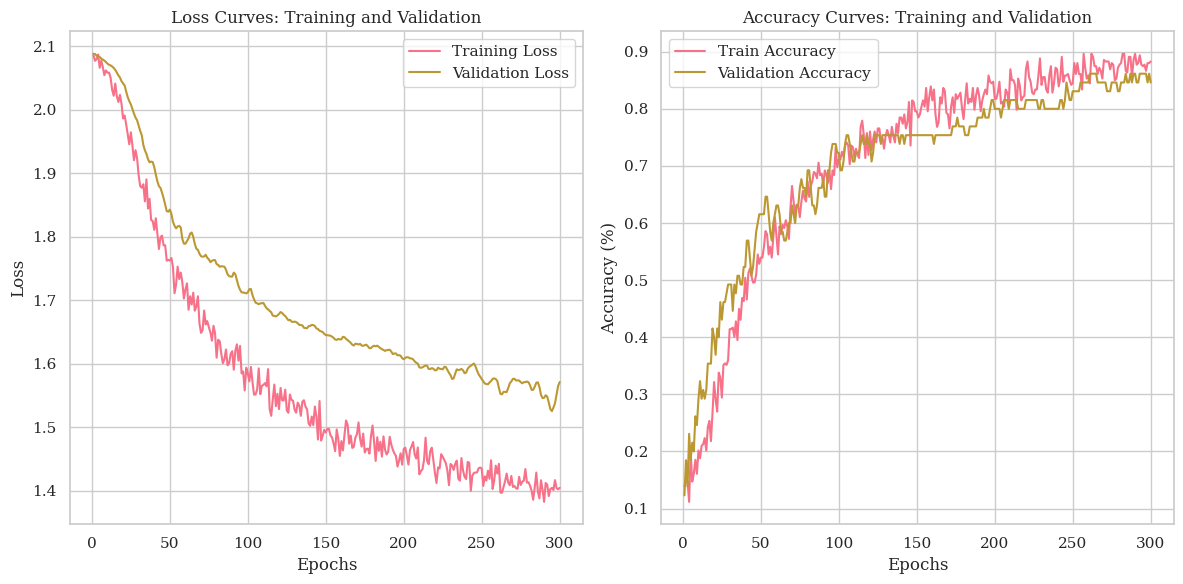

Test set Accuracy: 0.4375
Recall: 0.4375
F1 Score: 0.3986


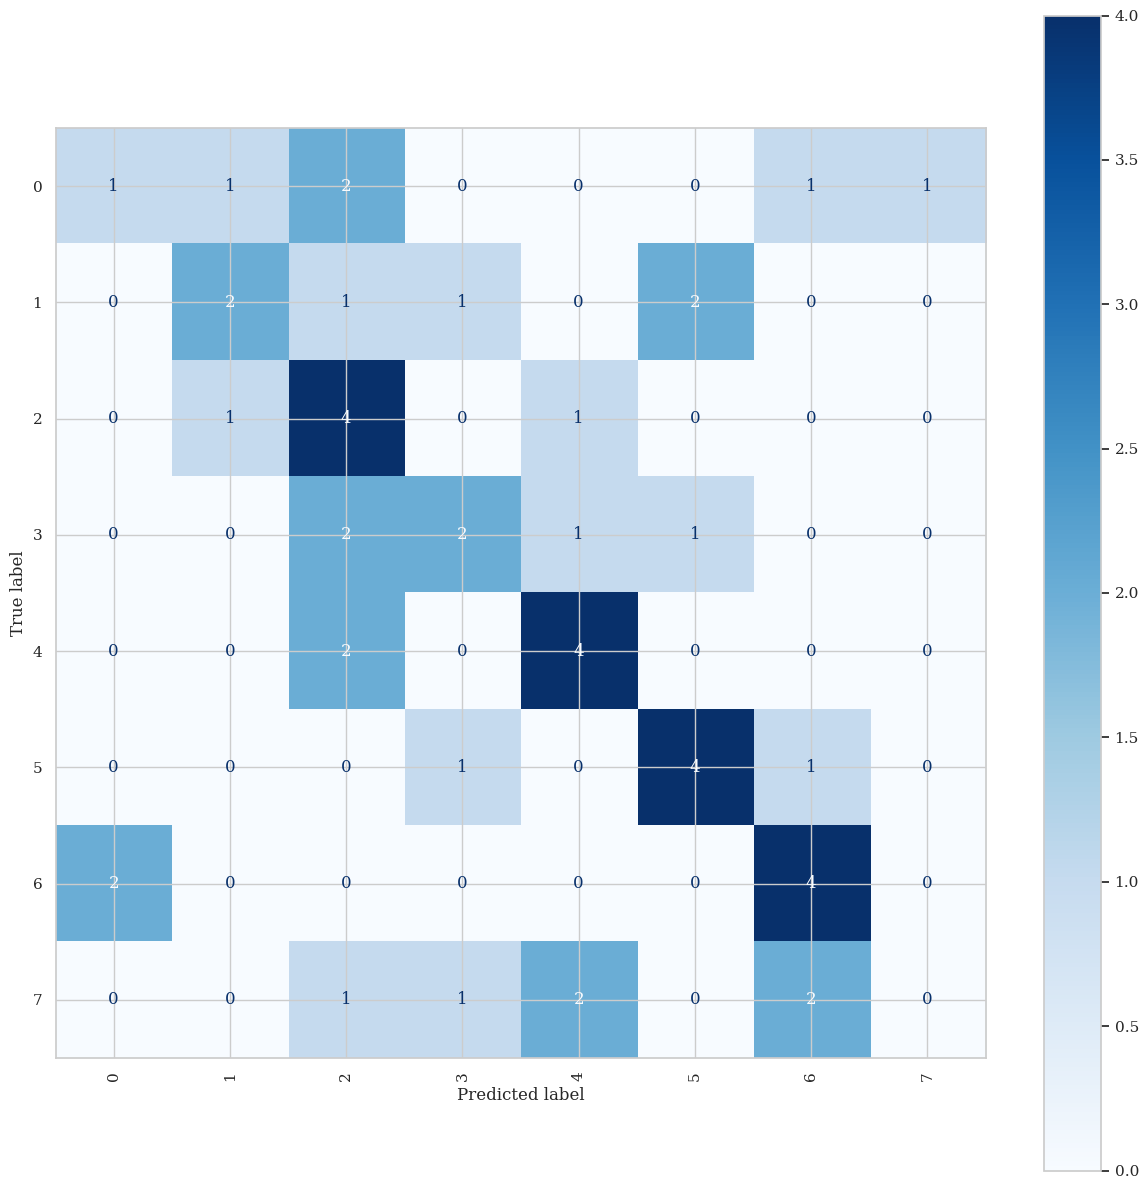

Usuário 9 Finalizado: Acurácia=0.4375, Recall=0.4375, F1=0.3986
--------------------------------------------------
Processando Usuário 10
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 3, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 3, 9, 250)
X_train: torch.Size([432, 3, 9, 250])
X_test: torch.Size([48, 3, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300: Train Loss: 2.0782, Train Accuracy: 0.1526, Val Loss: 2.0789, Val Accuracy: 0.0923
Epoch 2/300: Train Loss: 2.0780, Train Accuracy: 0.1362, Val Loss: 2.0787, Val Accuracy: 0.1077
Epoch 3/300: Train Loss: 2.0779, Train Accuracy: 0.1362, Val Loss: 2.0788, Val Accuracy: 0.1077
Epoch 4/300: Train Loss: 2.0765, Train Accuracy: 0.1253, Val Loss: 2.0785, Val Accuracy: 0.1077
Epoch 5/300: Train Loss: 2.0679, Train Accuracy: 0.1553, Val Loss: 2.0782, Val Accuracy: 0.1385
Epoch 6/300: Train Loss: 2.0695, Train Accuracy: 0.1553, Val Loss: 2.0777, Val Accuracy: 0.1231
Epoch 7/300: Train Loss: 2.0630, Train Accuracy: 0.1826, Val Loss: 2.0763, Val Accuracy: 0.1385
Epoch 8/300: Train Loss: 2.0584, Train Accuracy: 0.1689, Val Loss: 2.0749, Val Accuracy: 0.2000
Epoch 9/300: Train Loss: 2.0644, Train Accuracy: 0.1798, Val Loss: 2.0736, Val Accuracy: 0.1692
Epoch 10/300: Train Loss: 2.0585, Train Accuracy: 0.1935, Val Loss: 2.0729, Val Accuracy: 0.1538
Epoch 11/300: Train Loss: 2.0629, Train

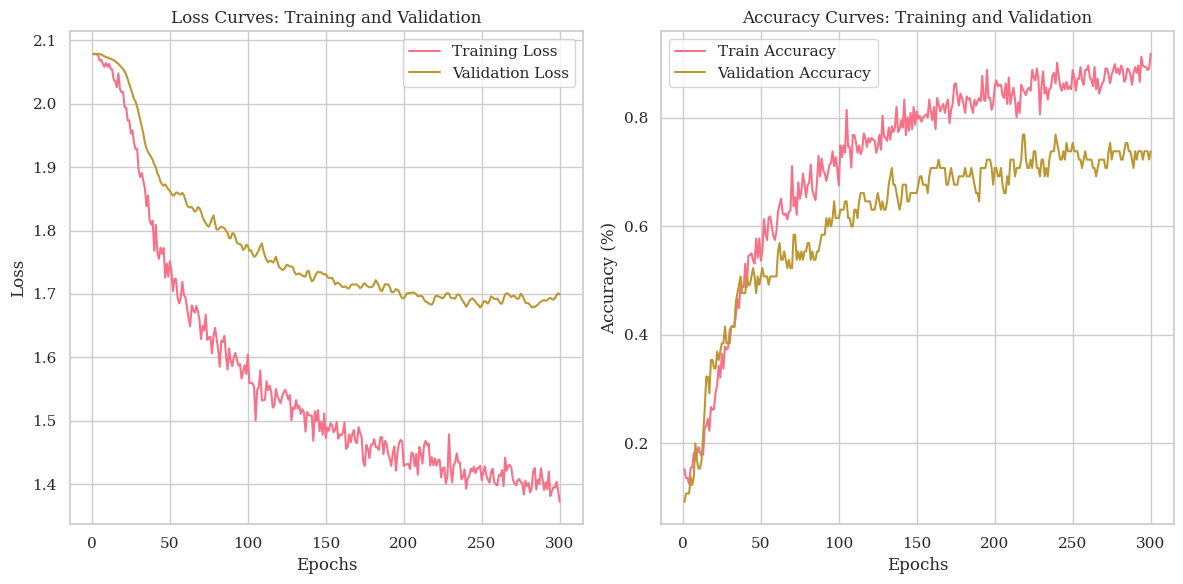

Test set Accuracy: 0.6875
Recall: 0.6875
F1 Score: 0.6844


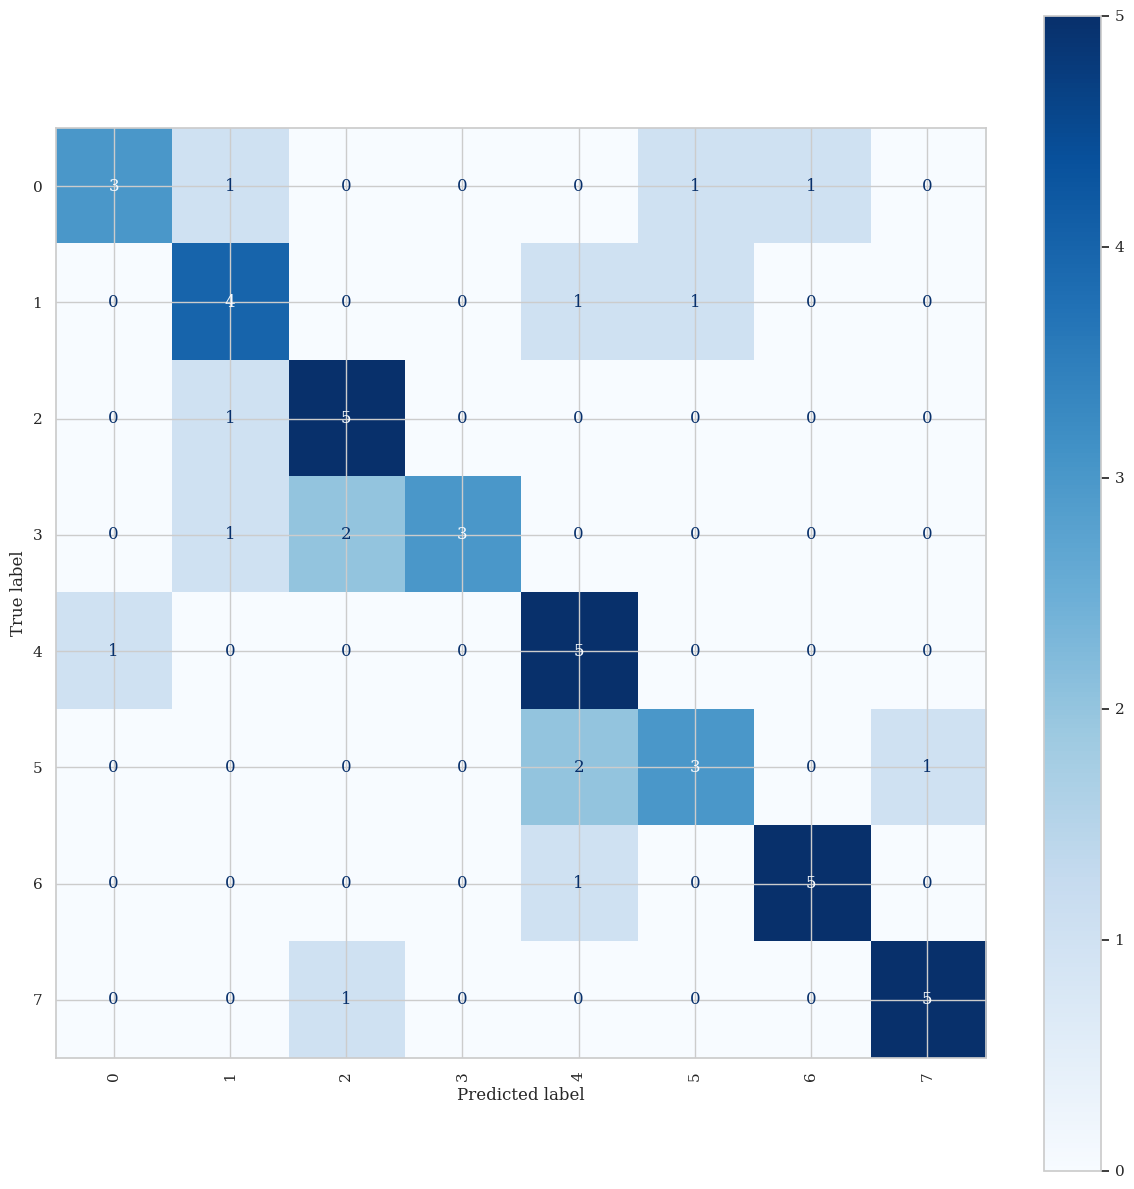

Usuário 10 Finalizado: Acurácia=0.6875, Recall=0.6875, F1=0.6844
--------------------------------------------------


In [60]:
seed = 42
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

metricas_usuarios = []
exp_dir.mkdir(parents=True, exist_ok=True)

for user in range(1, len(all_data) + 1):
    print(f"Processando Usuário {user}")
    n_freqs_sel = len(indices)
    metricas_crossval = []
    users_train = [u for u in range(1, len(all_data) + 1) if u != user]
    user_test = user

    x_train = []
    labels_train = []
    x_test = []
    labels_test = []

    # Train users
    for u in users_train:
        data = all_data[u - 1]
        for session in range(data.shape[3]):
            for freq in range(len(indices)):
                eeg_trial = data[occipital_electrodes, :, indices[freq], session]
                eeg_trial = eeg_trial[:, :tamanho_da_janela]
                x_train.append(eeg_trial)
                labels_train.extend([frequencias[freq]])
    x_train = np.array(x_train)
    x_train = filter_signals_subbands(x_train, subban_no=3, sampling_rate=250)

    # Test user
    data = all_data[user_test - 1]
    for session in range(data.shape[3]):
        for freq in range(len(indices)):
            eeg_trial = data[occipital_electrodes, :, indices[freq], session]
            eeg_trial = eeg_trial[:, :tamanho_da_janela]
            x_test.append(eeg_trial)
            labels_test.extend([frequencias[freq]])
    x_test = np.array(x_test)
    x_test = filter_signals_subbands(x_test, subban_no=3, sampling_rate=250)

    mapeamento = {rotulo: i for i, rotulo in enumerate(sorted(frequencias_desejadas))}
    labels_train = torch.tensor([mapeamento[rotulo.item()] for rotulo in labels_train])
    labels_test = torch.tensor([mapeamento[rotulo.item()] for rotulo in labels_test])

    X_train = torch.from_numpy(x_train.copy()).float().to(device)
    X_test = torch.from_numpy(x_test.copy()).float().to(device)
    Y_train = labels_train.to(torch.long).to(device)
    Y_test = labels_test.to(torch.long).to(device)
    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    print("Y_train:", Y_train.shape)
    print("Y_test:", Y_test.shape)

    model = FBCNN(
        num_classes=len(frequencias_desejadas),
        channels=9,
        samples=tamanho_da_janela,
        subbands=3,
    ).to(device)

    dataset = TensorDataset(X_train, Y_train)
    train_size = int(0.85 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(
        dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(seed),
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(
        TensorDataset(X_test, Y_test), batch_size=10, shuffle=False
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    best_model = train(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=epochs,
        device=device,
        save_path=exp_dir.joinpath(f"best_model_user_{user}.pth"),
    )
    accuracy, recall, f1, cm = evaluate(best_model, test_loader)
    metricas_crossval.append(
        {
            "usuario": user,
            "acuracia": accuracy,
            "recall": recall,
            "f1-score": f1,
            "confusion_matrix": cm,
        }
    )
    print(
        f"Usuário {user} Finalizado: Acurácia={accuracy:.4f}, Recall={recall:.4f}, F1={f1:.4f}"
    )
    metricas_usuarios.extend(metricas_crossval)
    df_metricas = pd.DataFrame(metricas_usuarios)
    df_metricas.to_csv(exp_dir.joinpath(f"metricas.csv"), index=False)
    print("-" * 50)